In [1]:
# df.dtypes
# obj_df = df.select_dtypes(include=['object']).copy()
# obj_df
# if all( x==2 for x in [df[column].value_counts().count() for column in list(df.select_dtypes(include=['object']).columns)]):
#   print("All object columns are binary variables.")
# sorted([(df[column].value_counts().count(),column) for column in list(df.columns)])
# df['absences'].value_counts().sort_index()
# average_component_size = mean([len(c) for c in list(component_iterable)])
# largest_component_size = len(max(nx.connected_components(G), key=len))


# Structure Learning comparison between the PC and HCS algorithm
## In this notebook, we are comparing the performance of two algorithms: PC and HCS. We use both to learn the structure of a bayesian network that fits the data from the dataset "Student Performance" by [Cortez and Silva (2008)](https://archive.ics.uci.edu/ml/datasets/student+performance).
### The following code cell is only needed to set up the environment on google colab (10.01.2022) and to download the dataset.

In [2]:
import os
from IPython.display import clear_output
if not os.path.isfile("./student-mat.csv"):
  !pip install pgmpy
  !sudo apt-get install graphviz graphviz-dev
  !pip install pygraphviz
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip -nc
  !unzip -o student.zip
  !wget -nc 'https://github.com/adiehl96/BayesianNetworks/raw/main/data/all_subgraphs.pickle'
  !wget -nc 'https://github.com/adiehl96/BayesianNetworks/raw/main/data/HCS_parameter_test.pickle'
  !wget -nc 'https://github.com/adiehl96/BayesianNetworks/raw/main/data/metric_test.pickle'
  !wget 'https://github.com/adiehl96/BayesianNetworks/raw/main/data/PC_parameter_test_min%3D1e-09_max%3D0.2_steps%3D100.pickle' -O PC_parameter_test_min=1e-09_max=0.2_steps=100.pickle

  clear_output()

In [3]:
from statistics import mean
from itertools import combinations
import random
import time, os, pickle
import multiprocessing as mp

from pgmpy.estimators import PC, ExhaustiveSearch, BicScore, BDeuScore, K2Score, BDsScore, MmhcEstimator, HillClimbSearch
from pgmpy.base import DAG
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import networkx.algorithms.approximation as nxaa

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
dpi=200

In [5]:
def print_graph(nodes, edges):
  G = nx.DiGraph()
  G.add_nodes_from(nodes)
  G.add_edges_from(edges)
  pos = nx.nx_agraph.graphviz_layout(G, prog='neato')
  options = {"with_labels": True, "node_color": "white", "edgecolors": "blue", "font_size":11, "node_size":2800}
  fig, axes = plt.subplots(figsize=(10, 10), dpi=dpi)

  nx.draw(G, pos, axes, **options)
  # nx.draw_shell(G,  **options)
  plt.show()

In [6]:
def flatten(the_lists):
    result = []
    for item in the_lists:
        if isinstance(item, list):
            result += item
        else:
            result.append(item)
    if any(isinstance(item, list) for item in result):
        result = flatten(result)
    return result

In [7]:
def keep_time(start_time, current_time, idx, length):
    time_elapsed_per_round = time.time()-current_time
    print(f"Processed {idx}/{length} subgraphs of in {time_elapsed_per_round} seconds.", end=" ")
    time_elapsed = time.time()-start_time
    total_time = ((time_elapsed/idx)*length)
    print(f"Time left: {(total_time - time_elapsed)/60} minutes")

In [8]:
def mean_per_size(metric_test, all_subgraphs, n):
  lists = []
  for i in range(19):
    current_list = []
    for idx, length in [(idx, len(x)) for idx, x in enumerate(all_subgraphs)]:
      if i == length:
        current_list.append(idx)
    lists.append(current_list)
  mean_results = []
  for i in range(1, 19):
    mean_val = 0
    for index in lists[i]:
      mean_val += metric_test[index][n]
    mean_val = mean_val / len(lists[i])
    mean_results.append(mean_val)
  return mean_results, lists

### Define metrics to compare two different networks

#### Metric1 is a metric based on edge density. The metric takes two graphs as input, the first one and the second one. The result is on a scale of -1 to 1, in which 1 is returned, when the first graph is fully connected and the second one has no edges. -1 represents the exact opposite situation, where the first graph has no edges and the second graph is fully connected.

In [9]:
def edge_density(nodes, edges):
  G = nx.DiGraph()
  G.add_nodes_from(nodes)
  G.add_edges_from(edges)
  G = G.to_undirected()
  return nx.density(G)

#Actual edges to possible edges ratio
def metric1(nodes1, edges1, nodes2, edges2):
  return edge_density(nodes1, edges1) - edge_density(nodes2, edges2)

#### Metric2 is based on isolated components. We want to track into how many isolated components our component is split. To do this, we gather all of these components. We then subtract the average size of the isolated components except for the largest from that of the size of the largest component. This value is then subtracted from the total amount of nodes, normalized and then shifted into a positive number range.



In [10]:
def connectedness_measure(nodes, edges):
  G = nx.DiGraph()
  G.add_nodes_from(nodes)
  G.add_edges_from(edges)
  G = G.to_undirected()
  component_iterable = nx.connected_components(G)
  sorted_component_list = sorted(nx.connected_components(G), key=len, reverse=True)
  largest_component_size = len(sorted_component_list.pop(0))
  average_component_size = mean([len(c) for c in sorted_component_list]) if sorted_component_list else 0
  return (1 - (len(G.nodes) - (largest_component_size - average_component_size))/len(G.nodes) )


def metric2(nodes1, edges1, nodes2, edges2):
  return connectedness_measure(nodes1, edges1) - connectedness_measure(nodes2, edges2)

### Preprocessing the data
In the following cell, we simplify our data. We keep all nodes in the network, but we bin certain variables to have fewer possible states. This includes the variables "absences", "G3" and "age". For binary variables, we convert their values to numbers, to be able to use regression algorithms.

In [11]:
df = pd.read_csv('student-mat.csv', sep=';')[["Dalc", "G3", "Pstatus", "Walc", "absences", "activities", "age", "failures", "famrel", "famsup", "freetime", "goout", "health", "higher", "paid", "schoolsup", "sex", "studytime"]]
df = df.dropna(axis='index')
cleanup_binary = {"Pstatus":    {"T": 0, "A": 1},
                  "activities": {"no": 0, "yes": 1},
                  "famsup":     {"no": 0, "yes": 1},
                  "higher":     {"no": 0, "yes": 1},
                  "paid":       {"no": 0, "yes": 1},
                  "schoolsup":  {"no": 0, "yes": 1},
                  "sex":        {"F": 0, "M": 1},
                }
df = df.replace(cleanup_binary)
df['absences'] = pd.cut(df['absences'], bins=[0, 5, 10, 15, 300],  include_lowest=True).cat.codes.astype("int64")
df['G3'] =       pd.cut(df['G3'],       bins=[0, 5, 10, 15, 20],   include_lowest=True).cat.codes.astype("int64")
df['age'] =      pd.cut(df['age'],      bins=[15, 16, 18, 20, 22], include_lowest=True).cat.codes.astype("int64")
# df = df[["G3", "famrel", "health", "absences", "Dalc", "Pstatus"]]
df = df.astype("int8")
df

,Dalc,G3,Pstatus,Walc,absences,activities,age,failures,famrel,famsup,freetime,goout,health,higher,paid,schoolsup,sex,studytime
0,1,1,1,1,1,0,1,0,4,0,3,4,3,1,0,1,0,2
1,1,1,0,1,0,0,1,0,5,1,3,3,3,1,0,0,0,2
2,2,1,0,3,1,0,0,3,4,0,3,2,3,1,1,1,0,2
3,1,2,0,1,0,1,0,0,3,1,2,2,5,1,1,0,0,3
4,1,1,0,2,0,0,0,0,4,1,3,2,5,1,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,4,1,1,5,2,0,2,2,5,1,5,4,4,1,1,0,1,2
391,3,3,0,4,0,0,1,0,2,0,4,5,2,1,0,0,1,1
392,3,1,0,3,0,0,3,3,5,0,5,3,3,1,0,0,1,1
393,3,1,0,4,0,0,1,0,4,0,4,1,5,1,0,0,1,1


### Experiments
In the following cells, we prepare the experiments that we want to run. Most of these functions are quite slow, given the amount of samples that they have to process. To amortise their usage, we pickle their results and simply read from that if the correct pickle is present.

In [12]:
def compare_algorithms_all_subgraphs():
  global metric_test
  if os.path.isfile(f"./metric_test.pickle") and os.path.isfile(f"./all_subgraphs.pickle"):
    metric_test = pickle.load(open(f"./metric_test.pickle", "rb"))
    all_subgraphs = pickle.load(open(f"./all_subgraphs.pickle", "rb"))
    return metric_test, all_subgraphs
  else:
    all_subgraphs = flatten([list(combinations(df.columns, n)) for n in range(1, len(df.columns)+1)])[:1000] # remove permutations
    def metric_test(inp):
      (idx, subgraph) = inp
      print(f"Processing subgraph #{idx}.")
      subdf = df[list(subgraph)]
      est_PC = PC(data=subdf).estimate(
        variant="stable",
        ci_test="pearsonr",
        max_cond_vars=5,
        return_type="pdag",
        significance_level=0.01,
        show_progress=False,
      )
      est_HCS = HillClimbSearch(data=subdf).estimate(
        scoring_method=K2Score(data=df),
        start_dag=None,
        fixed_edges={},
        tabu_length=1000,
        max_indegree=None,
        black_list=None,
        white_list=None,
        epsilon=0.00001,
        max_iter=1000000.0,
        show_progress=False,
      )
      m1 = metric1(
        list(df.columns), list(est_PC.edges), list(df.columns), list(est_HCS.edges)
      )
      m2 = metric2(
        list(df.columns), list(est_PC.edges), list(df.columns), list(est_HCS.edges)
      )
      ed1 = edge_density(list(df.columns), list(est_PC.edges))

      ed2 = edge_density(list(df.columns), list(est_HCS.edges))

      cm1 = connectedness_measure(list(df.columns), list(est_PC.edges))

      cm2 = connectedness_measure(list(df.columns), list(est_HCS.edges))

      return (idx, m1, m2, ed1, ed2, cm1, cm2, list(est_PC.edges), list(est_HCS.edges))   

    pool = mp.Pool(mp.cpu_count())
    print("mp.cpu_count(): ", mp.cpu_count())
    start_time = time.time()
    result = pool.map(metric_test, enumerate(all_subgraphs))
    print(result)
    time_elapsed = time.time()-start_time
    print(f"time elapsed since start: {time_elapsed} seconds")
    pickle.dump(result, open(f"metric_test.pickle", "wb"))
    pickle.dump(all_subgraphs, open(f"all_subgraphs.pickle", "wb"))

  return result, all_subgraphs

In [13]:
def distributed_parameter_test_PC(min=0.000001, max=0.5, steps=10):
  global result
  global PC_parameter_test
  if os.path.isfile(f"./PC_parameter_test_min={min}_max={max}_steps={steps}.pickle"):
    result = pickle.load(open(f"PC_parameter_test_min={min}_max={max}_steps={steps}.pickle", "rb"))
  else:
    print("mp.cpu_count(): ", mp.cpu_count())
    def PC_parameter_test(inp):
      (idx, significane_level) = inp
      
      est_PC = PC(data=df).estimate(
          variant="stable",
          ci_test="pearsonr",
          max_cond_vars=5,
          return_type="pdag",
          significance_level=significane_level,
          show_progress=False,
      )
      ed = edge_density(list(df.columns), list(est_PC.edges))

      cm = connectedness_measure(list(df.columns), list(est_PC.edges))
      print(f"Processed significane level #{idx}:  {significane_level}.")
      return (idx, ed, cm, list(est_PC.edges))
    
    pool = mp.Pool(mp.cpu_count())
    start_time = time.time()
    result = pool.map(
      PC_parameter_test,
      zip(range(steps), np.linspace(min, max, steps)),
    )
    time_elapsed = time.time() - start_time
    print(f"time elapsed since start: {time_elapsed} seconds")
    pickle.dump(result, open(f"PC_parameter_test_min={min}_max={max}_steps={steps}.pickle", "wb"))
  return result

In [14]:
def parameter_test_HCS():
  if os.path.isfile(f"./HCS_parameter_test.pickle"):
    results = pickle.load(open(f"./HCS_parameter_test.pickle", "rb"))
  else:
    start_dag1 = None

    start_dag2 = DAG()
    start_dag2.add_edges_from([('Pstatus', 'famrel'), ('famrel', 'famsup'), ('famrel', 'absences'), ('famrel', 'health'), ('health', 'G3'), ('famsup', 'studytime'), ('famsup', 'freetime'), ('sex', 'Walc'), ('sex', 'Dalc'), ('sex', 'studytime'), ('sex', 'G3'), ('age', 'G3'), ('age', 'goout'), ('age', 'failures'), ('age', 'higher'), ('schoolsup', 'freetime'), ('schoolsup', 'studytime'), ('paid', 'freetime'), ('paid', 'studytime'), ('activities', 'freetime'), ('higher', 'Dalc'), ('higher', 'studytime'), ('higher', 'G3'), ('higher', 'failures'), ('freetime', 'health'), ('goout', 'Walc'), ('goout', 'Dalc'), ('goout', 'freetime'), ('Dalc', 'Walc'), ('Dalc', 'health'), ('Dalc', 'studytime'), ('Walc', 'health'), ('Walc', 'studytime'), ('absences', 'G3'), ('failures', 'G3'), ('studytime', 'G3'), ('studytime', 'freetime')])

    start_dag3 = DAG()
    generated_edges = list(nx.gnp_random_graph(18,1,directed=True).edges())
    generated_edges = [(u,v) for (u,v) in generated_edges if u<v]
    for idx, edge in enumerate(generated_edges):
      generated_edges[idx] = (list(df.columns)[edge[0]], list(df.columns)[edge[1]])
    random.shuffle(generated_edges)
    generated_edges = generated_edges[:50]
    start_dag3.add_edges_from(generated_edges)
    
    results = []
    for idx, start_dag in enumerate([start_dag1, start_dag2, start_dag3]):
      est_HCS = HillClimbSearch(data=df).estimate(scoring_method=K2Score(data=df), 
                                                  start_dag=start_dag, 
                                                  fixed_edges={}, 
                                                  tabu_length=1000, 
                                                  max_indegree=None, 
                                                  black_list=None, 
                                                  white_list=None, 
                                                  epsilon=0.00001, 
                                                  max_iter=1000000.0, 
                                                  show_progress=True)
      ed = edge_density(list(df.columns), list(est_HCS.edges))
      cm = connectedness_measure(list(df.columns), list(est_HCS.edges))
      print(f"Processed graph #{idx}.")
      results.append((idx, ed, cm, list(est_HCS.edges)))
    pickle.dump(results, open(f"HCS_parameter_test.pickle", "wb"))
  return results

In [15]:
def new_parameter_test_HCS(min_n=0, max_n=50):
  if os.path.isfile(f"./HCS_parameter_test_min_n_{min_n}_max_n_{max_n}.pickle"):
    results = pickle.load(open(f"./HCS_parameter_test_min_n_{min_n}_max_n_{max_n}.pickle", "rb"))
  else:
    start_dags = []
    for i in range(min_n, max_n):
      if i == 0:
        start_dags.append(None)
        continue
      start_dag = DAG()
      generated_edges = list(nx.gnp_random_graph(18,1,directed=True).edges())
      generated_edges = [(u,v) for (u,v) in generated_edges if u<v]
      for idx, edge in enumerate(generated_edges):
        generated_edges[idx] = (list(df.columns)[edge[0]], list(df.columns)[edge[1]])
      random.shuffle(generated_edges)
      generated_edges = generated_edges[:i]
      start_dag.add_nodes_from(df.columns)
      start_dag.add_edges_from(generated_edges)
      start_dags.append(start_dag)
    
    results=[]
    for idx, start_dag in enumerate(start_dags):
      est_HCS = HillClimbSearch(data=df).estimate(scoring_method=K2Score(data=df), 
                                                  start_dag=start_dag, 
                                                  fixed_edges={}, 
                                                  tabu_length=1000, 
                                                  max_indegree=None, 
                                                  black_list=None, 
                                                  white_list=None, 
                                                  epsilon=0.00001, 
                                                  max_iter=1000000.0, 
                                                  show_progress=True)
      ed = edge_density(list(df.columns), list(est_HCS.edges))
      cm = connectedness_measure(list(df.columns), list(est_HCS.edges))
      print(f"Processed graph #{idx}.")
      results.append((idx, ed, cm, list(est_HCS.edges)))
    pickle.dump(results, open(f"HCS_parameter_test_min_n_{min_n}_max_n_{max_n}.pickle", "wb"))
  return results

### Experiment 1: Influence of the significance value on PC performanc
In order to find out how this value affects the results of the PC algorithm, we will run the algorithm 100 times, from small to high significance values. Three of the resulting PDAGs will be visually inspected to look for obvious trends or shortcomings in the results. Additionally, we will look at how our metrics evaluate the resulting graphs.

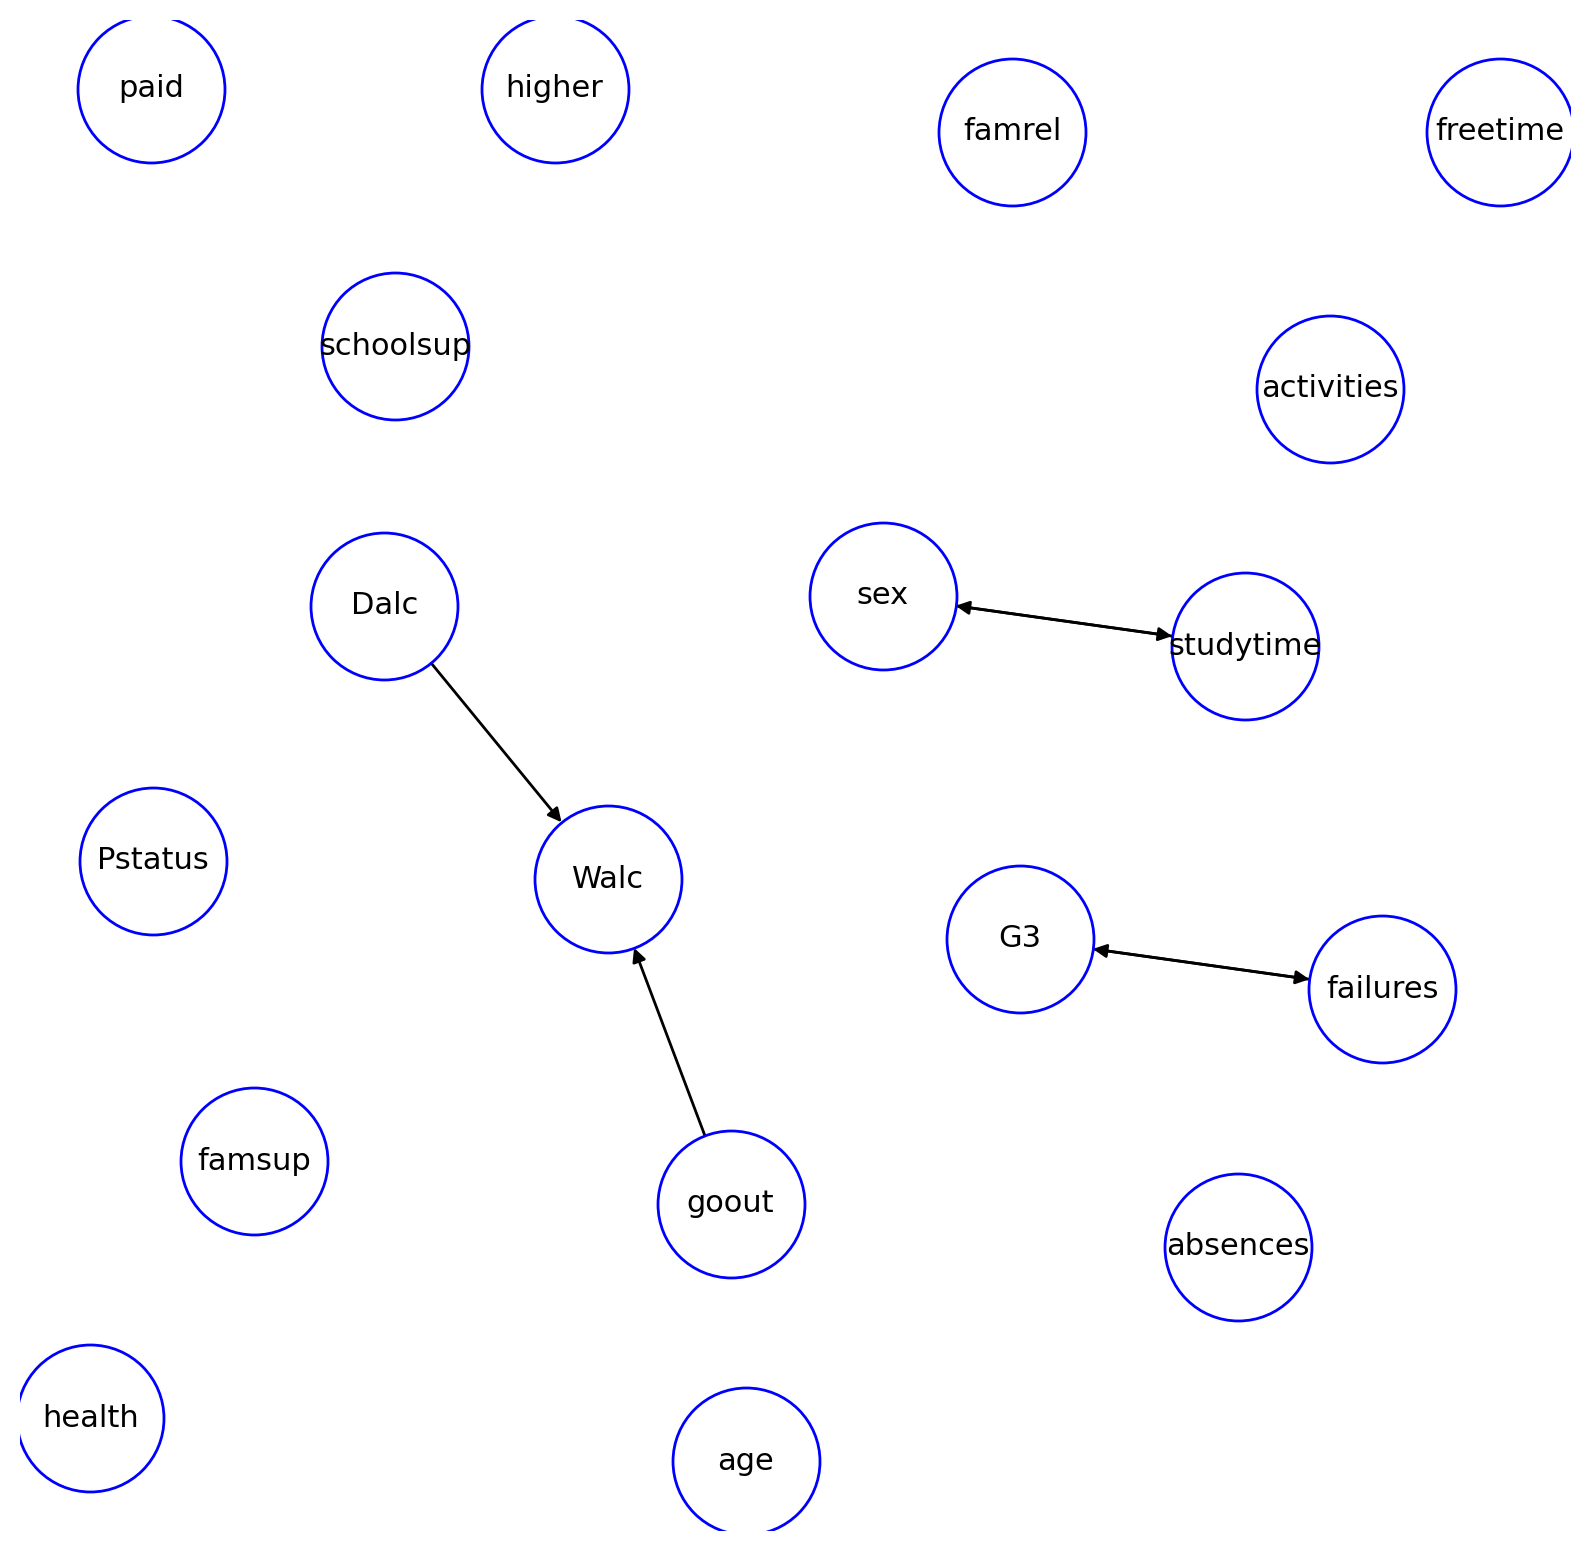

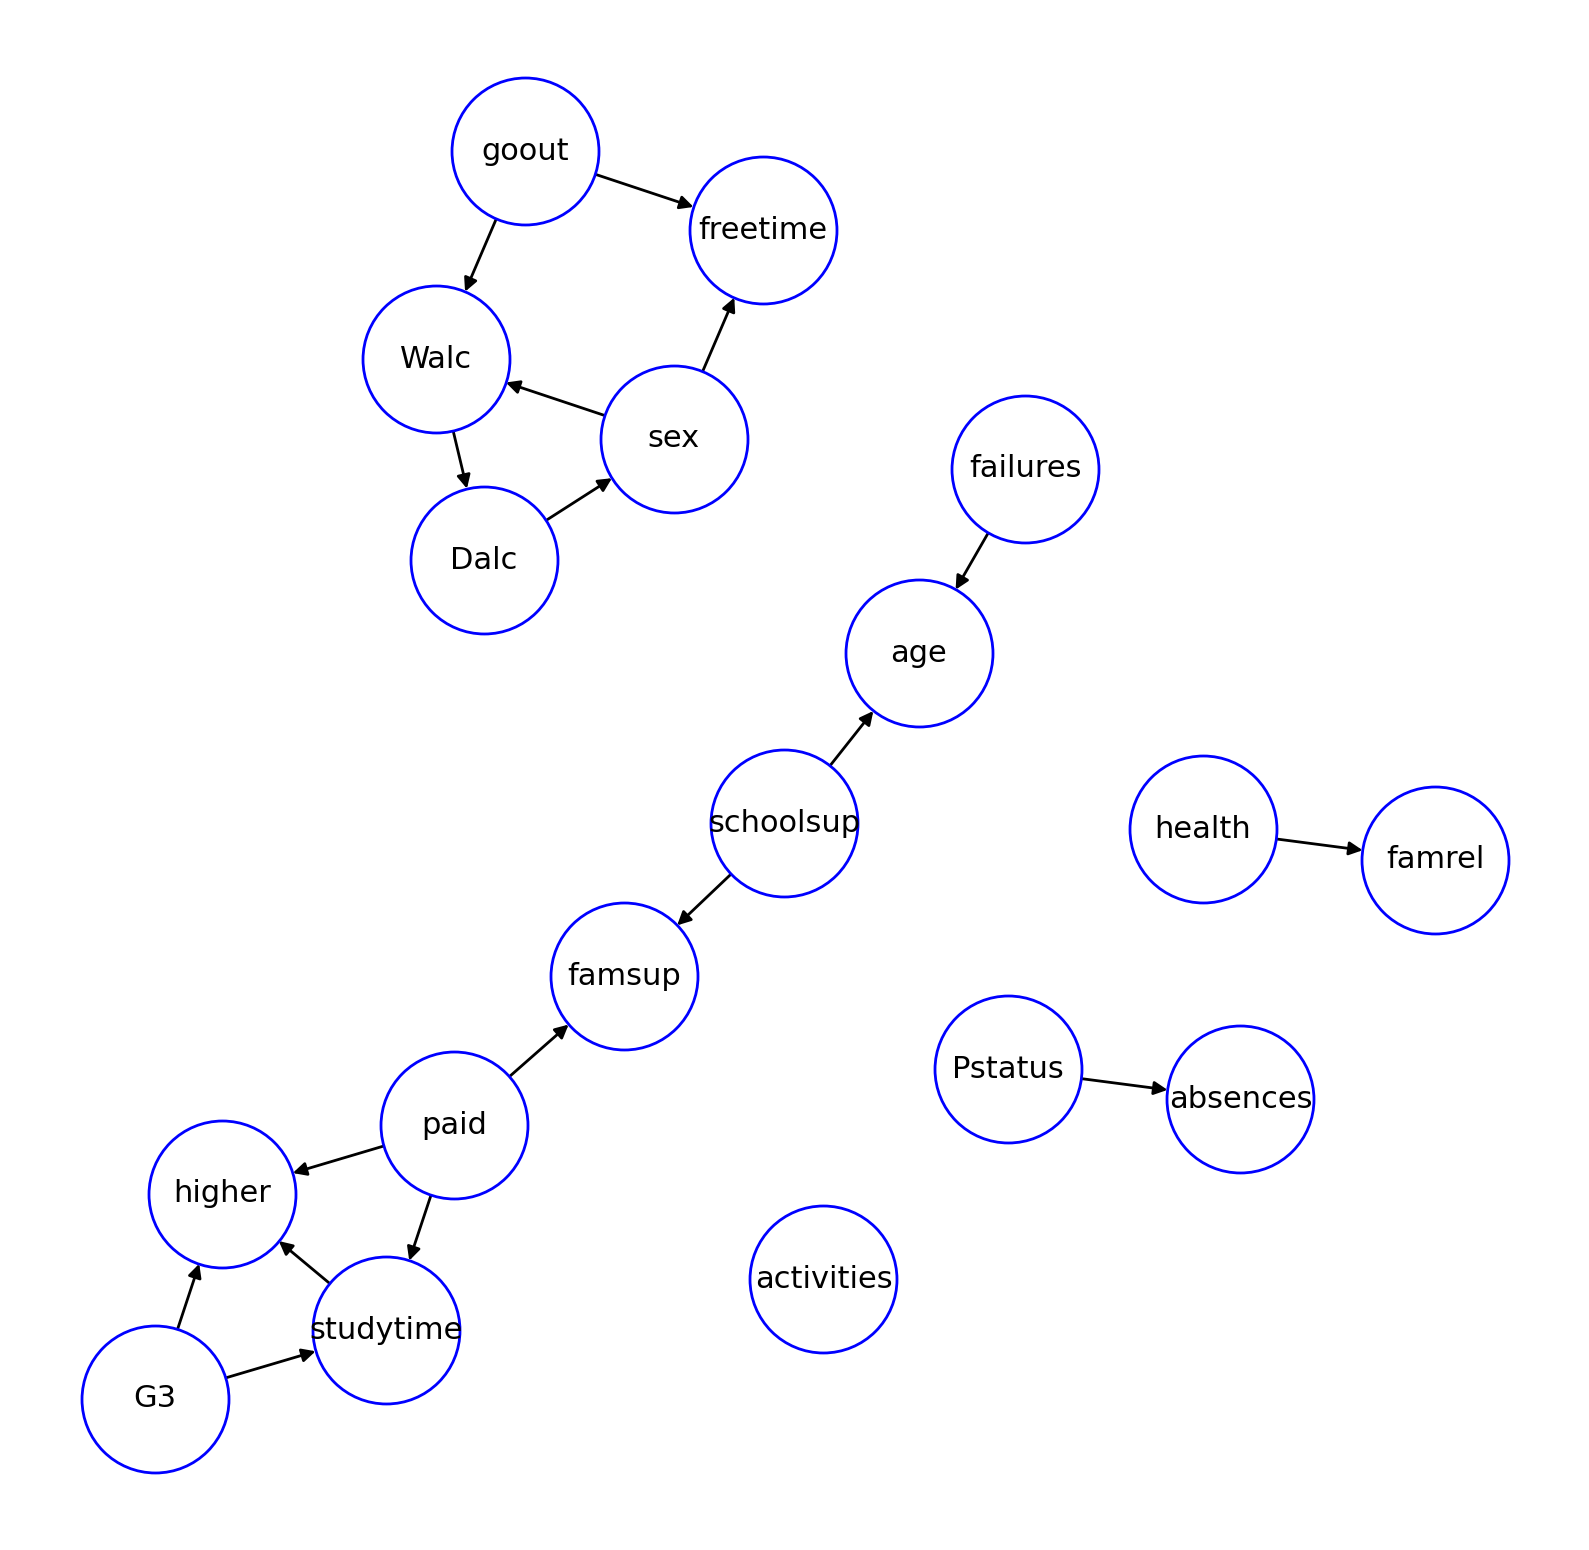

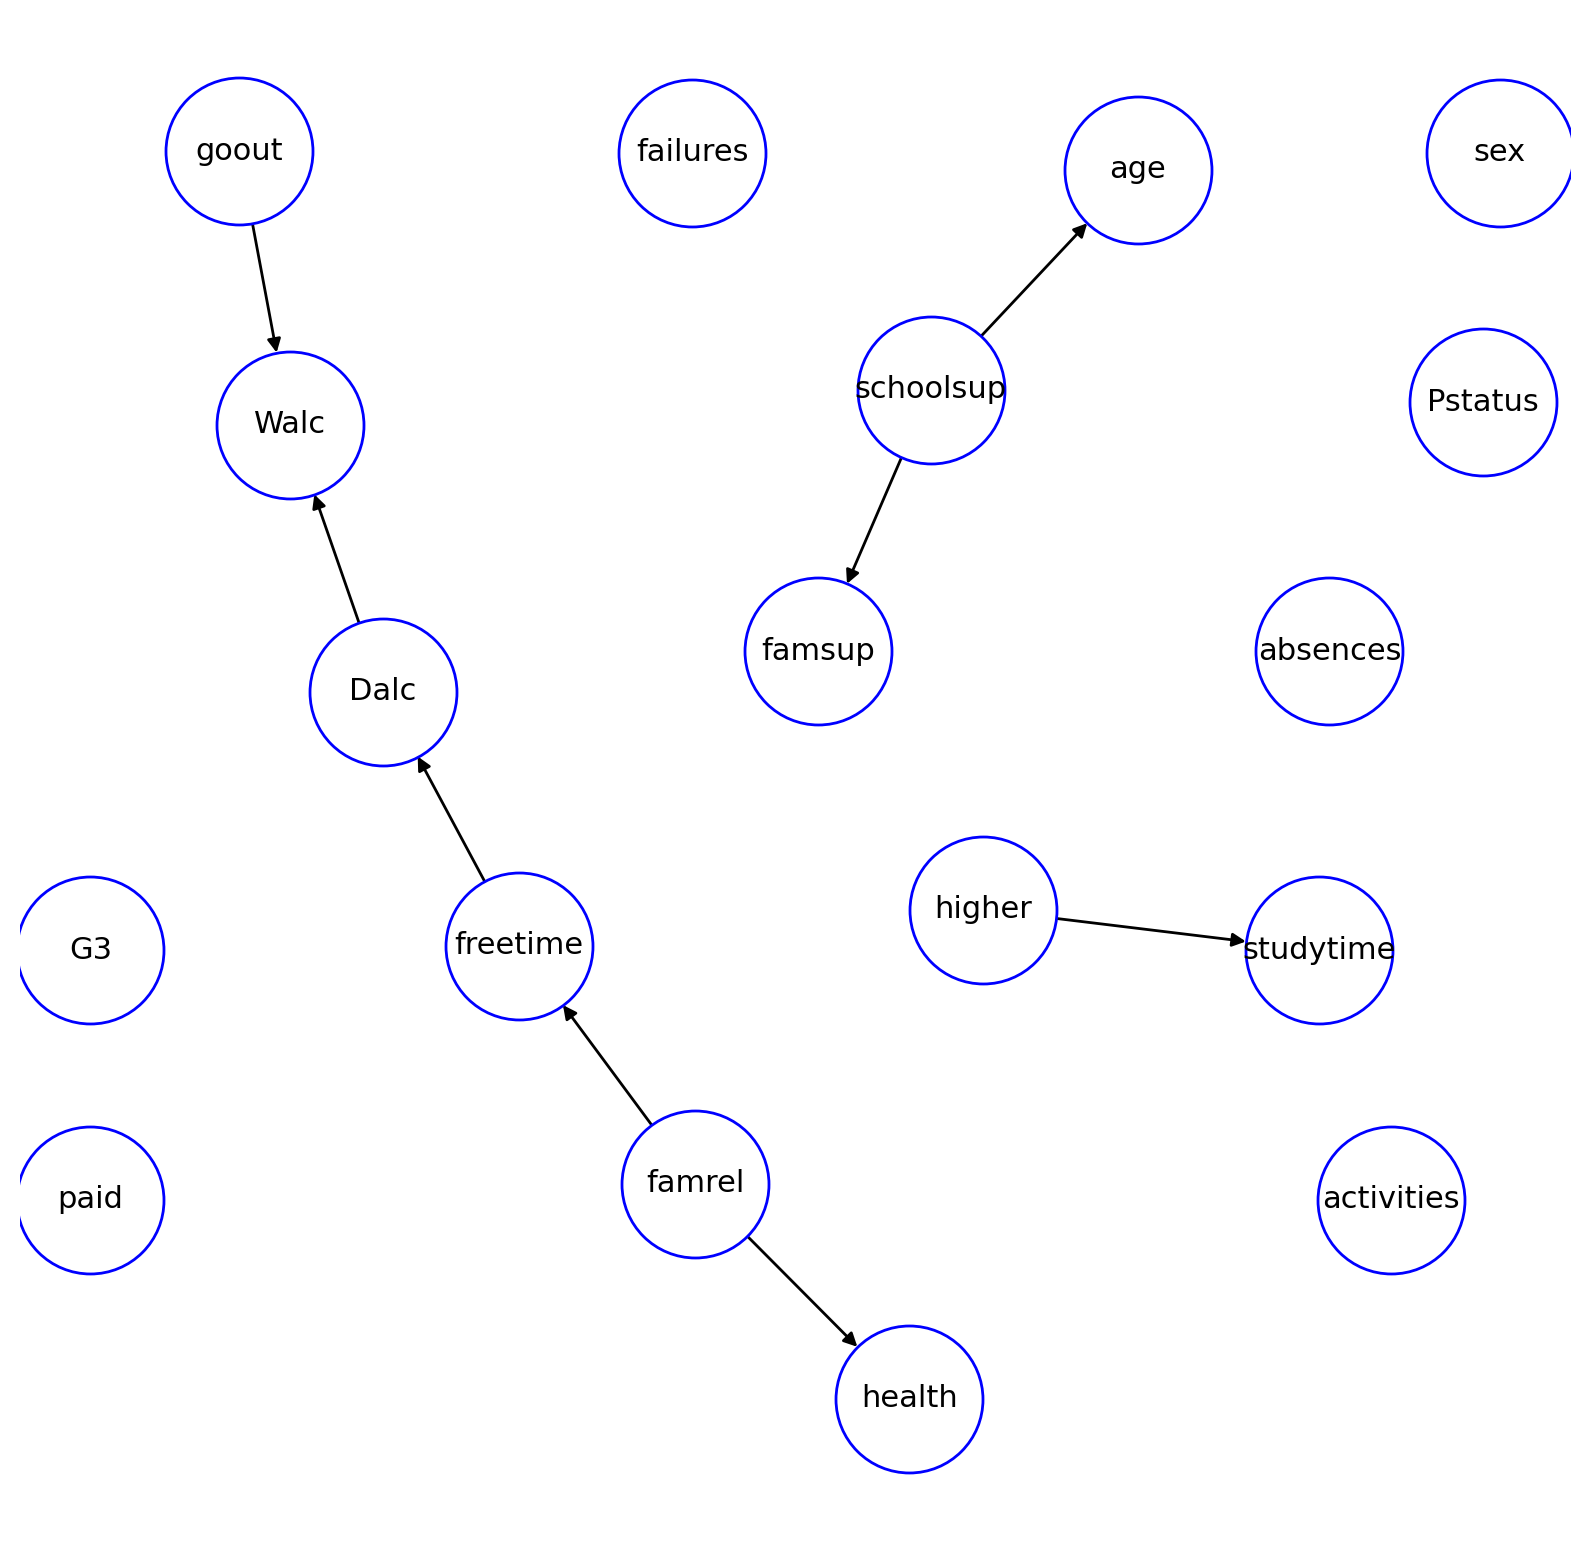

In [16]:
min1=0.000000001
max1=0.2
steps1=100
result = distributed_parameter_test_PC(min1, max1, steps1)
pdags = [x[3] for x in result]
pdags = [pdags[0], pdags[50], pdags[-1] ]
for pdag in pdags:
  print_graph(list(df.columns), pdag)

We can see in these results, that with an increase in the significance level comes an increase in the amount of edges found. However, with very large significance levels, there comes a reduction in the amount of edges.

#### Experiment1: Metric 1

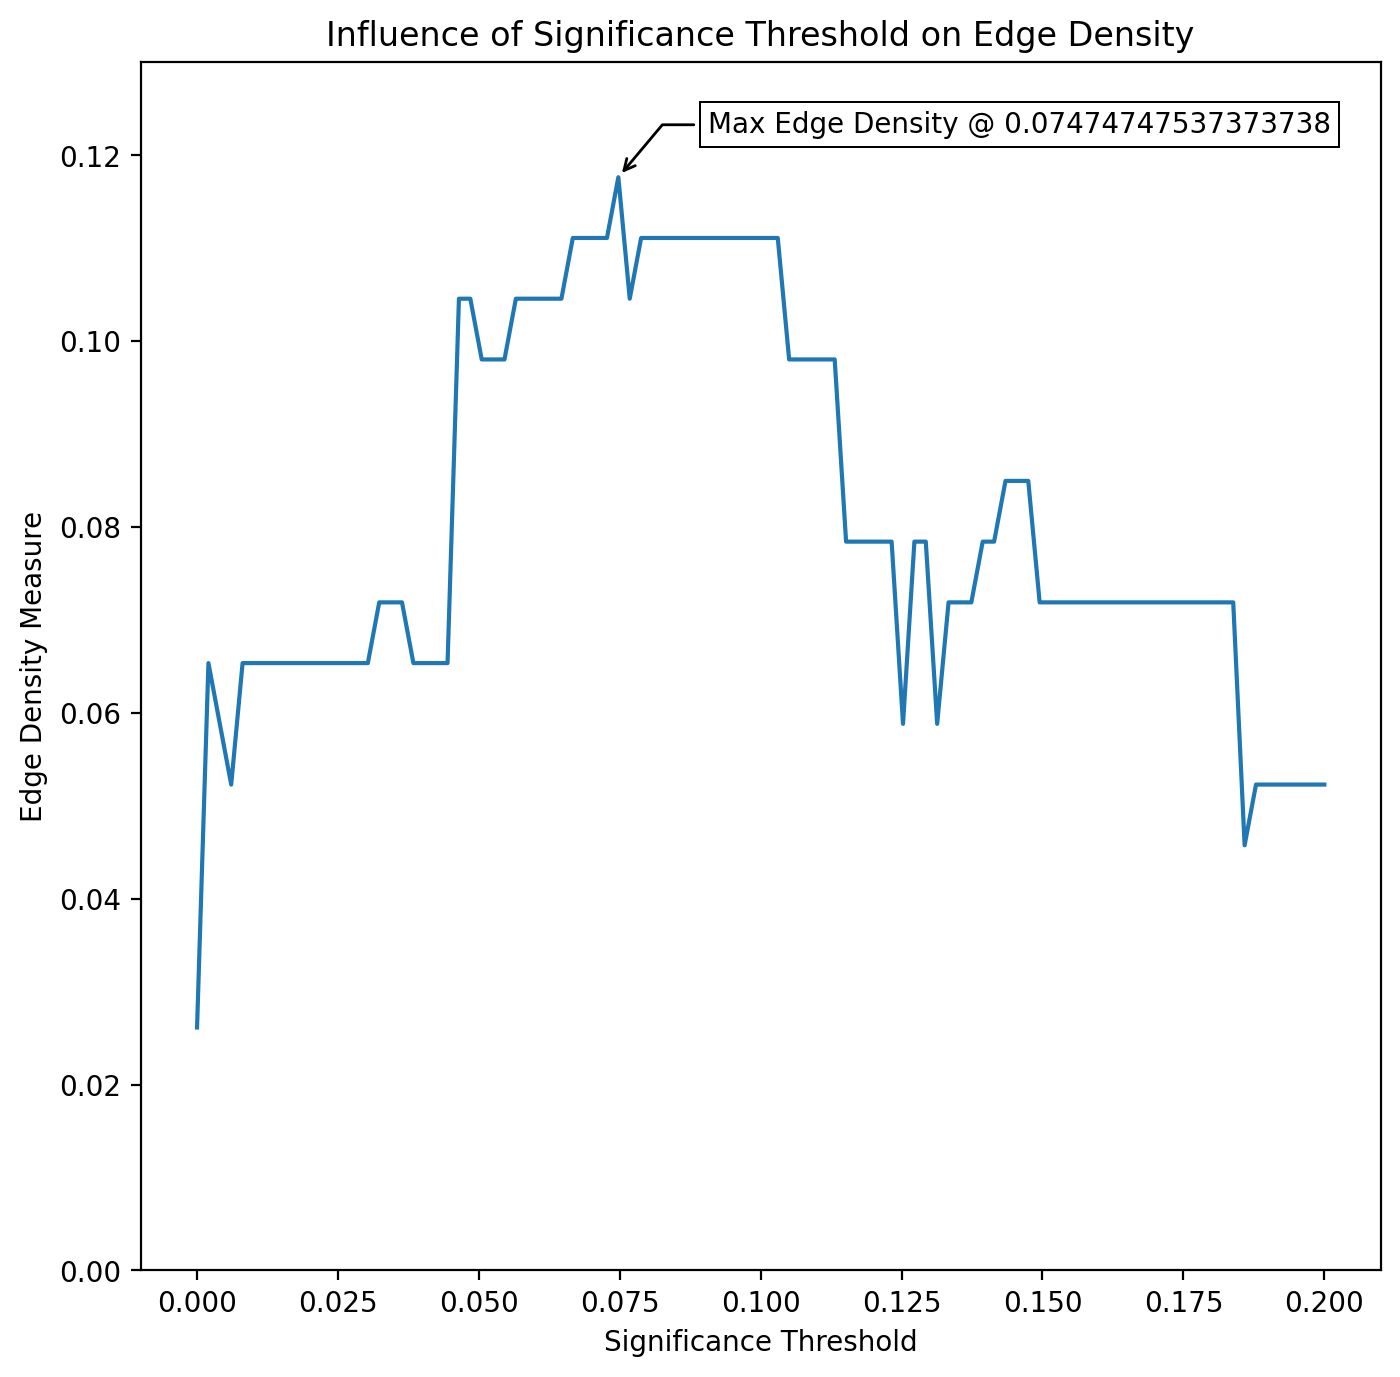

In [17]:
fig, ax=plt.subplots(figsize=(8, 8), dpi=dpi)
plt.plot(np.linspace(min1, max1, steps1), [x[1] for x in result], )
plt.title('Influence of Significance Threshold on Edge Density') 
plt.ylabel('Edge Density Measure')
plt.xlabel('Significance Threshold')
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    text= f"Max Edge Density @ {xmax}"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=50")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.96,0.96), **kw)

annot_max(np.linspace(min1, max1, steps1), [x[1] for x in result])
ax.set_ylim(0,0.13)
plt.show()

Our edge density metric is responsive to the trend noticed in the manual inspection, as we can clearly see that the edge density peaks somewhere between the tested minimum and the tested maximum. In this case, the peak happens at a significance value of 0.07474.

#### Experiment1: Metric 2

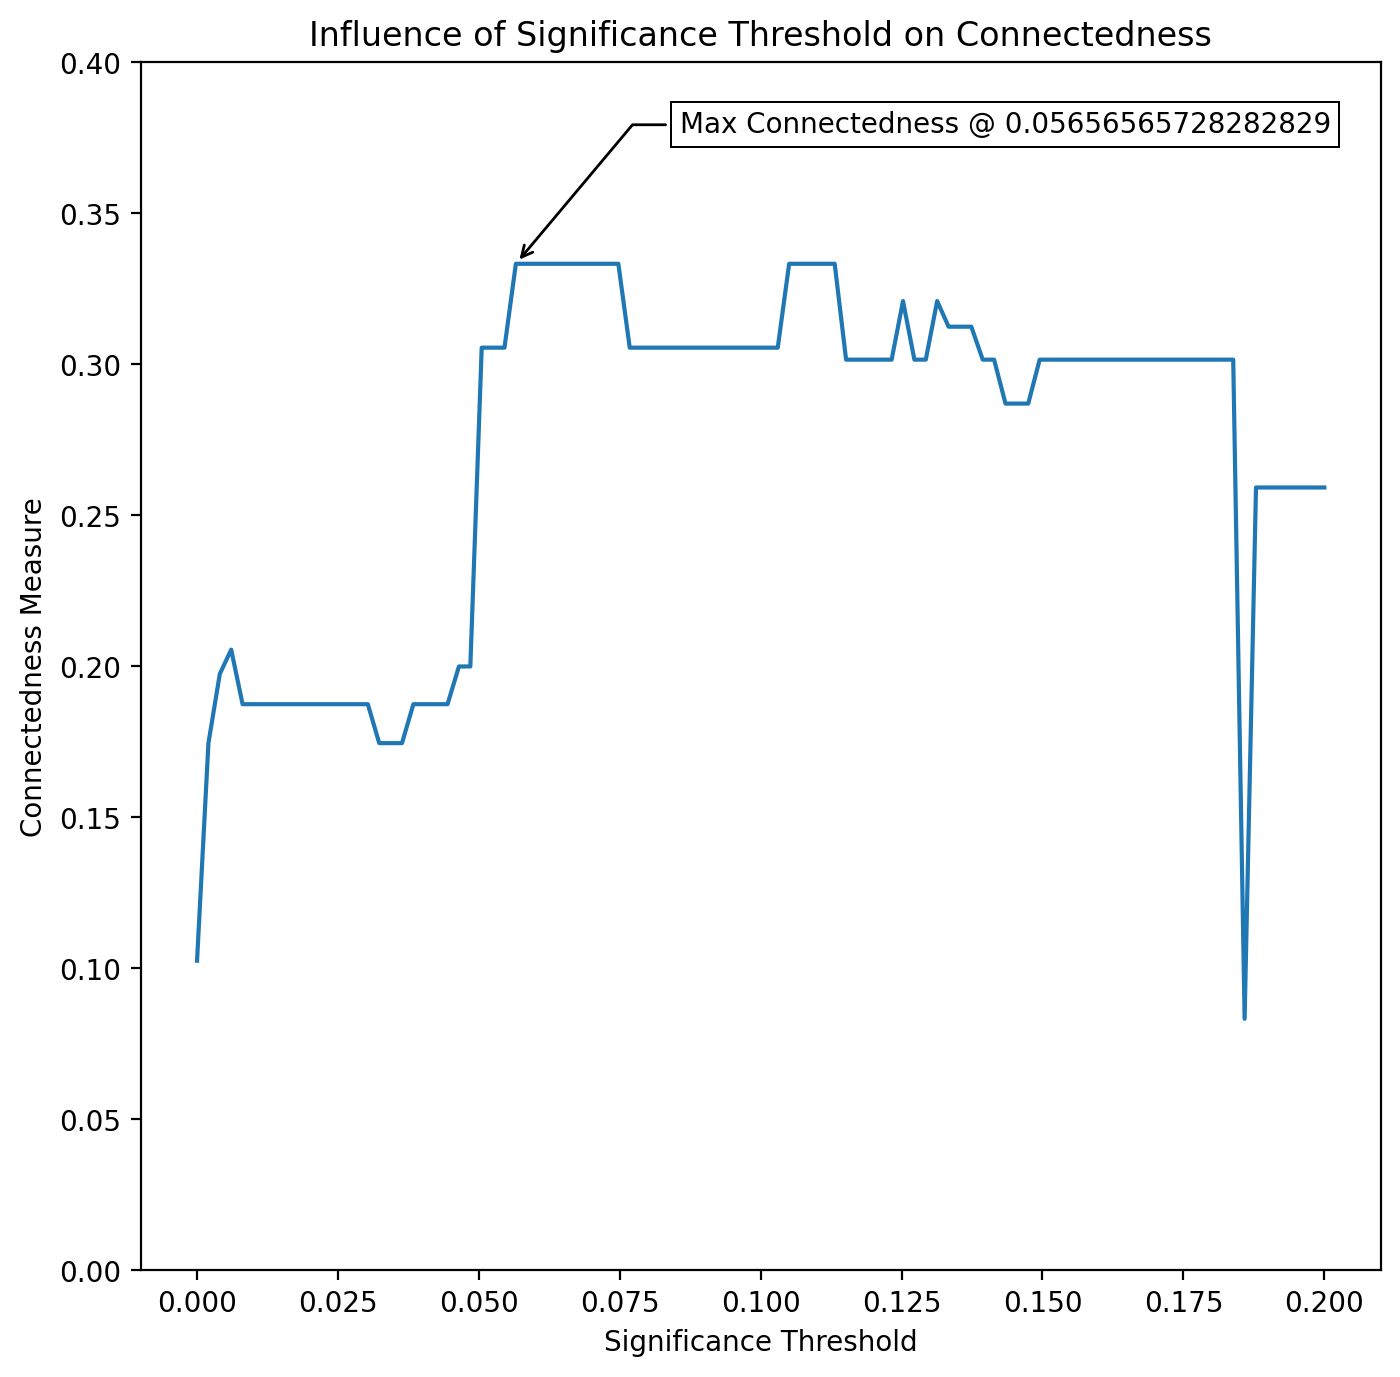

In [18]:
fig, ax=plt.subplots(figsize=(8, 8), dpi=dpi)
plt.plot(np.linspace(min1, max1, steps1), [x[2] for x in result], )
plt.title('Influence of Significance Threshold on Connectedness') 
plt.ylabel('Connectedness Measure')
plt.xlabel('Significance Threshold')
print()
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    text= f"Max Connectedness @ {xmax}"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=50")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.96,0.96), **kw)

annot_max(np.linspace(min1, max1, steps1), [x[2] for x in result])
ax.set_ylim(0,0.4)
plt.show()

Our connectedness measure has a similar trajectory compared to our edge density measure. However, the peak is not as pronounced and looks more like a plateau. The previous signficance value of 0.07474 is again a maximum for this metric. This suggests that the ideal significance value might be 0.07474 for our data and our interpretation of the data. We will work with this value in the following experiments.

### Experiment 2: Influence of the starting graph on HCS performance
In order to find out how this value affects the results of the HCS algorithm, we will run the algorithm 3 times with different startig graphs, ranging from a graph with no edges, to our own network to a graph with 50 edges (the maximum that can be processed on colab before the session crashes).  The resulting PDAGs will be visually inspected to look for obvious trends or shortcomings in the results. Additionally, we will look at how our metrics evaluate the resulting graphs.

In [19]:
# min_n=0
# max_n=5
# result_new_HCS = new_parameter_test_HCS(min_n=min_n, max_n=max_n)
# pdags = [x[3] for x in result_new_HCS]
# pdags = [pdags[0], pdags[round(max_n/2)], pdags[-1] ]
# for pdag in pdags:
#   print_graph(list(df.columns), pdag)

In [20]:
# fig, ax=plt.subplots(figsize=(8, 8), dpi=dpi)
# plt.plot(range(0,5), [x[1] for x in result_new_HCS], )
# plt.title('Influence of start dag size on Edge Density') 
# plt.ylabel('Edge Density Measure')
# plt.xlabel('Significance Threshold')
# # plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
# # plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
# def annot_max(x,y, ax=None):
#     xmax = x[np.argmax(y)]
#     ymax = np.max(y)
#     text= f"Max Edge Density @ {xmax}"
#     if not ax:
#         ax=plt.gca()
#     bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
#     arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=-50")
#     kw = dict(xycoords='data',textcoords="axes fraction",
#               arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
#     ax.annotate(text, xy=(xmax, ymax), xytext=(0.86,0.96), **kw)

# annot_max(range(0,5), [x[1] for x in result_new_HCS])
# ax.set_ylim(0,0.15)
# plt.show()

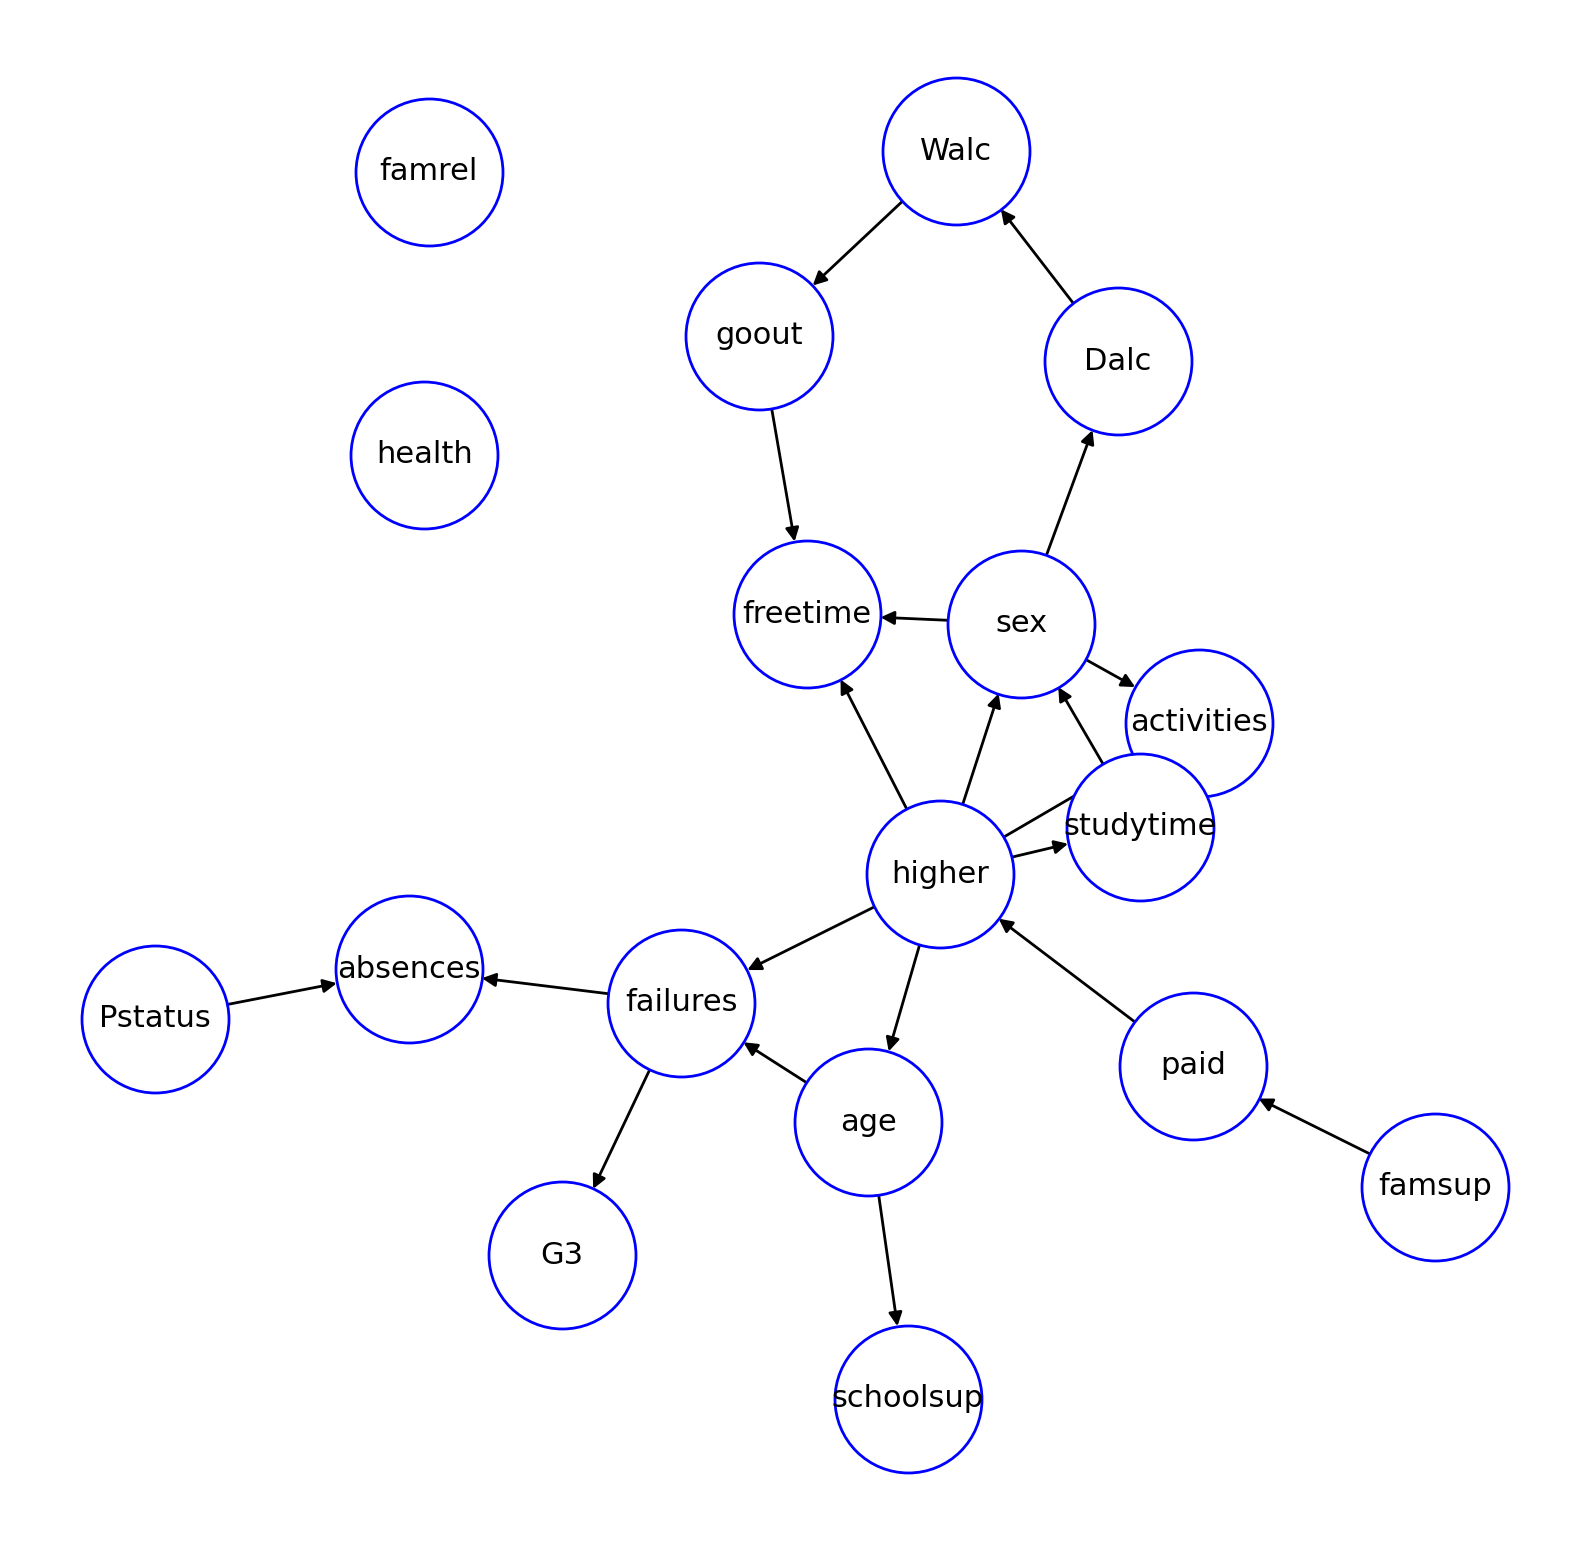

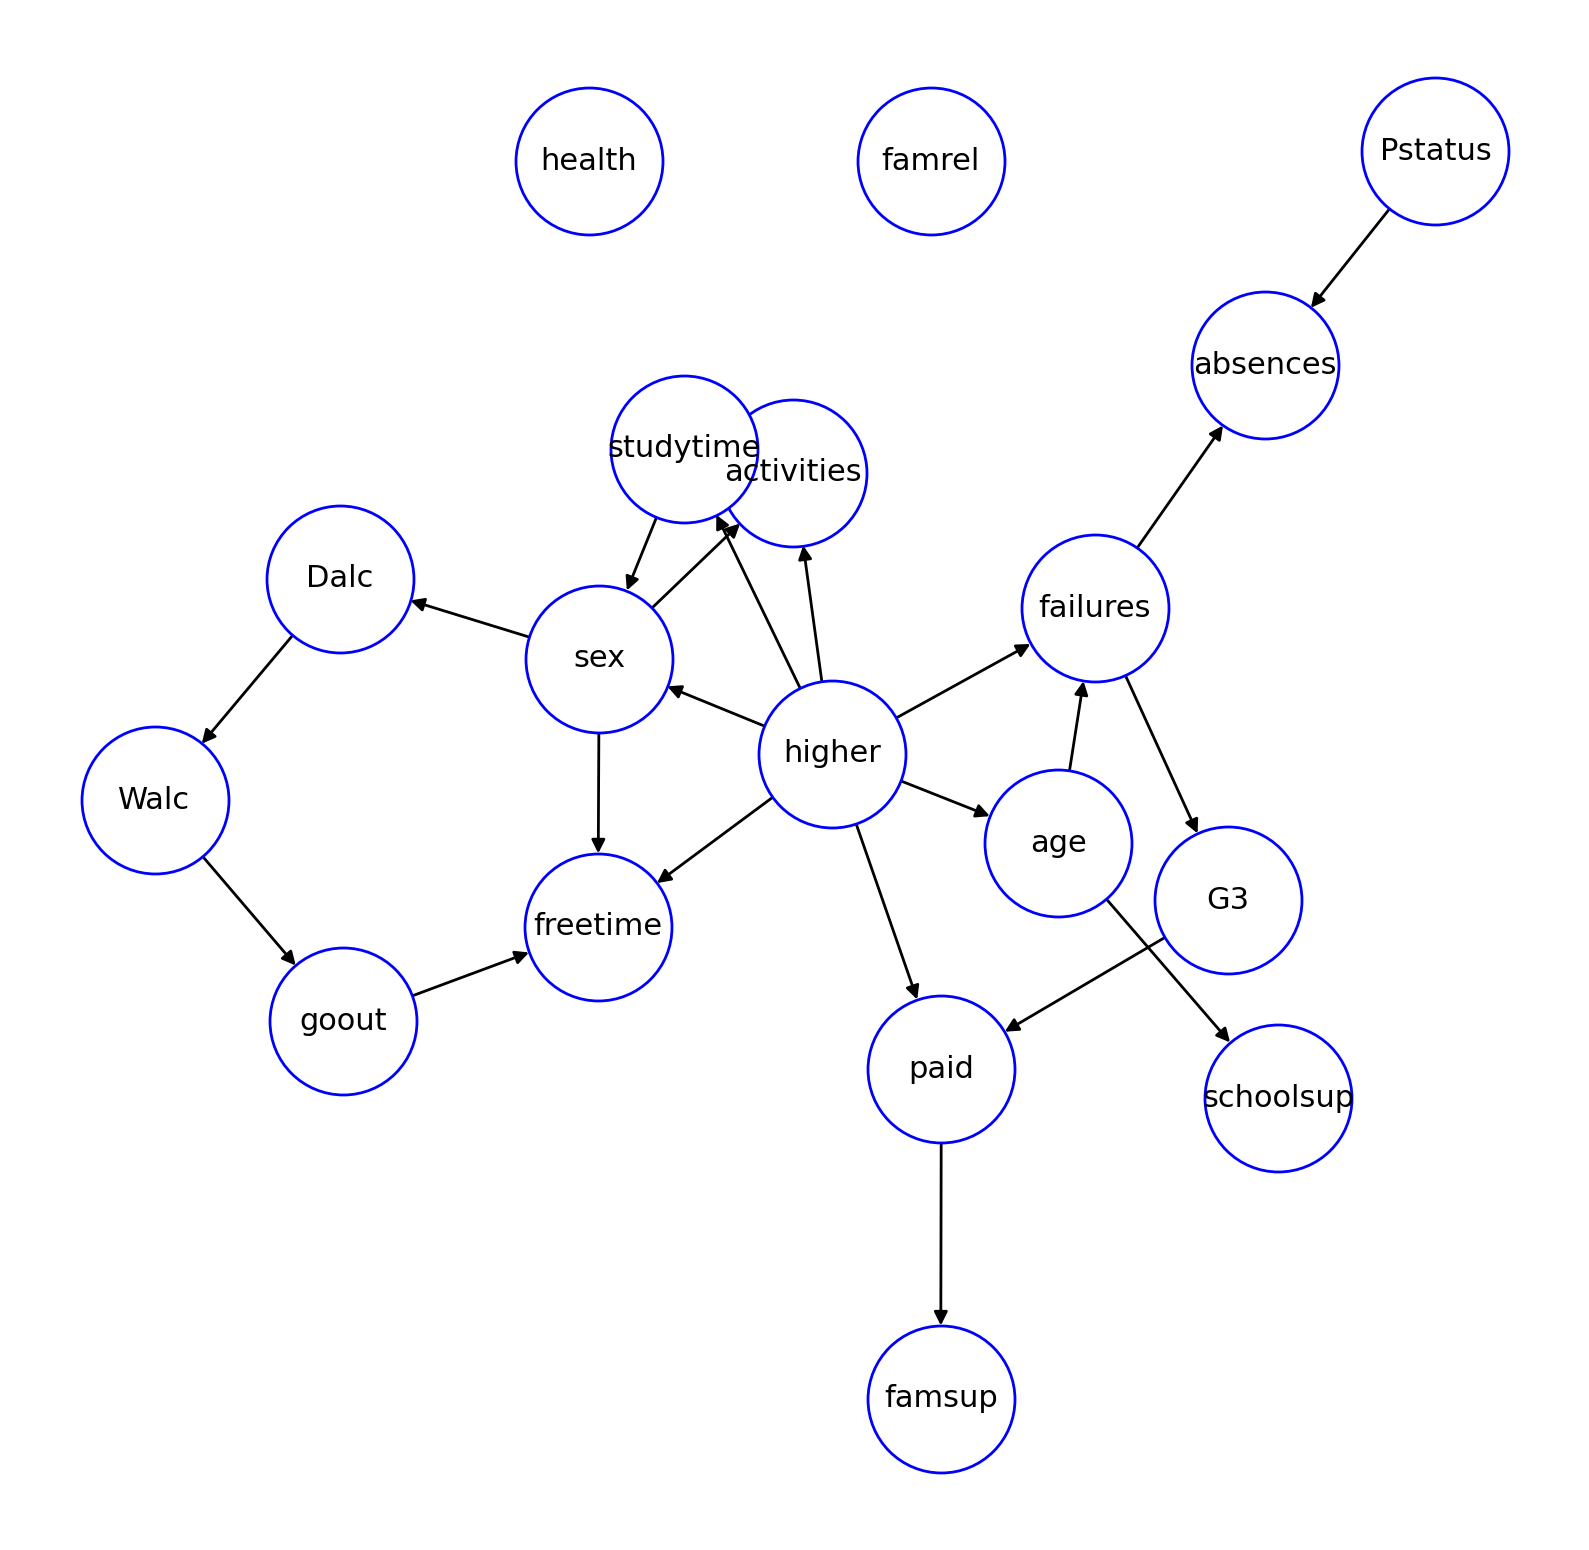

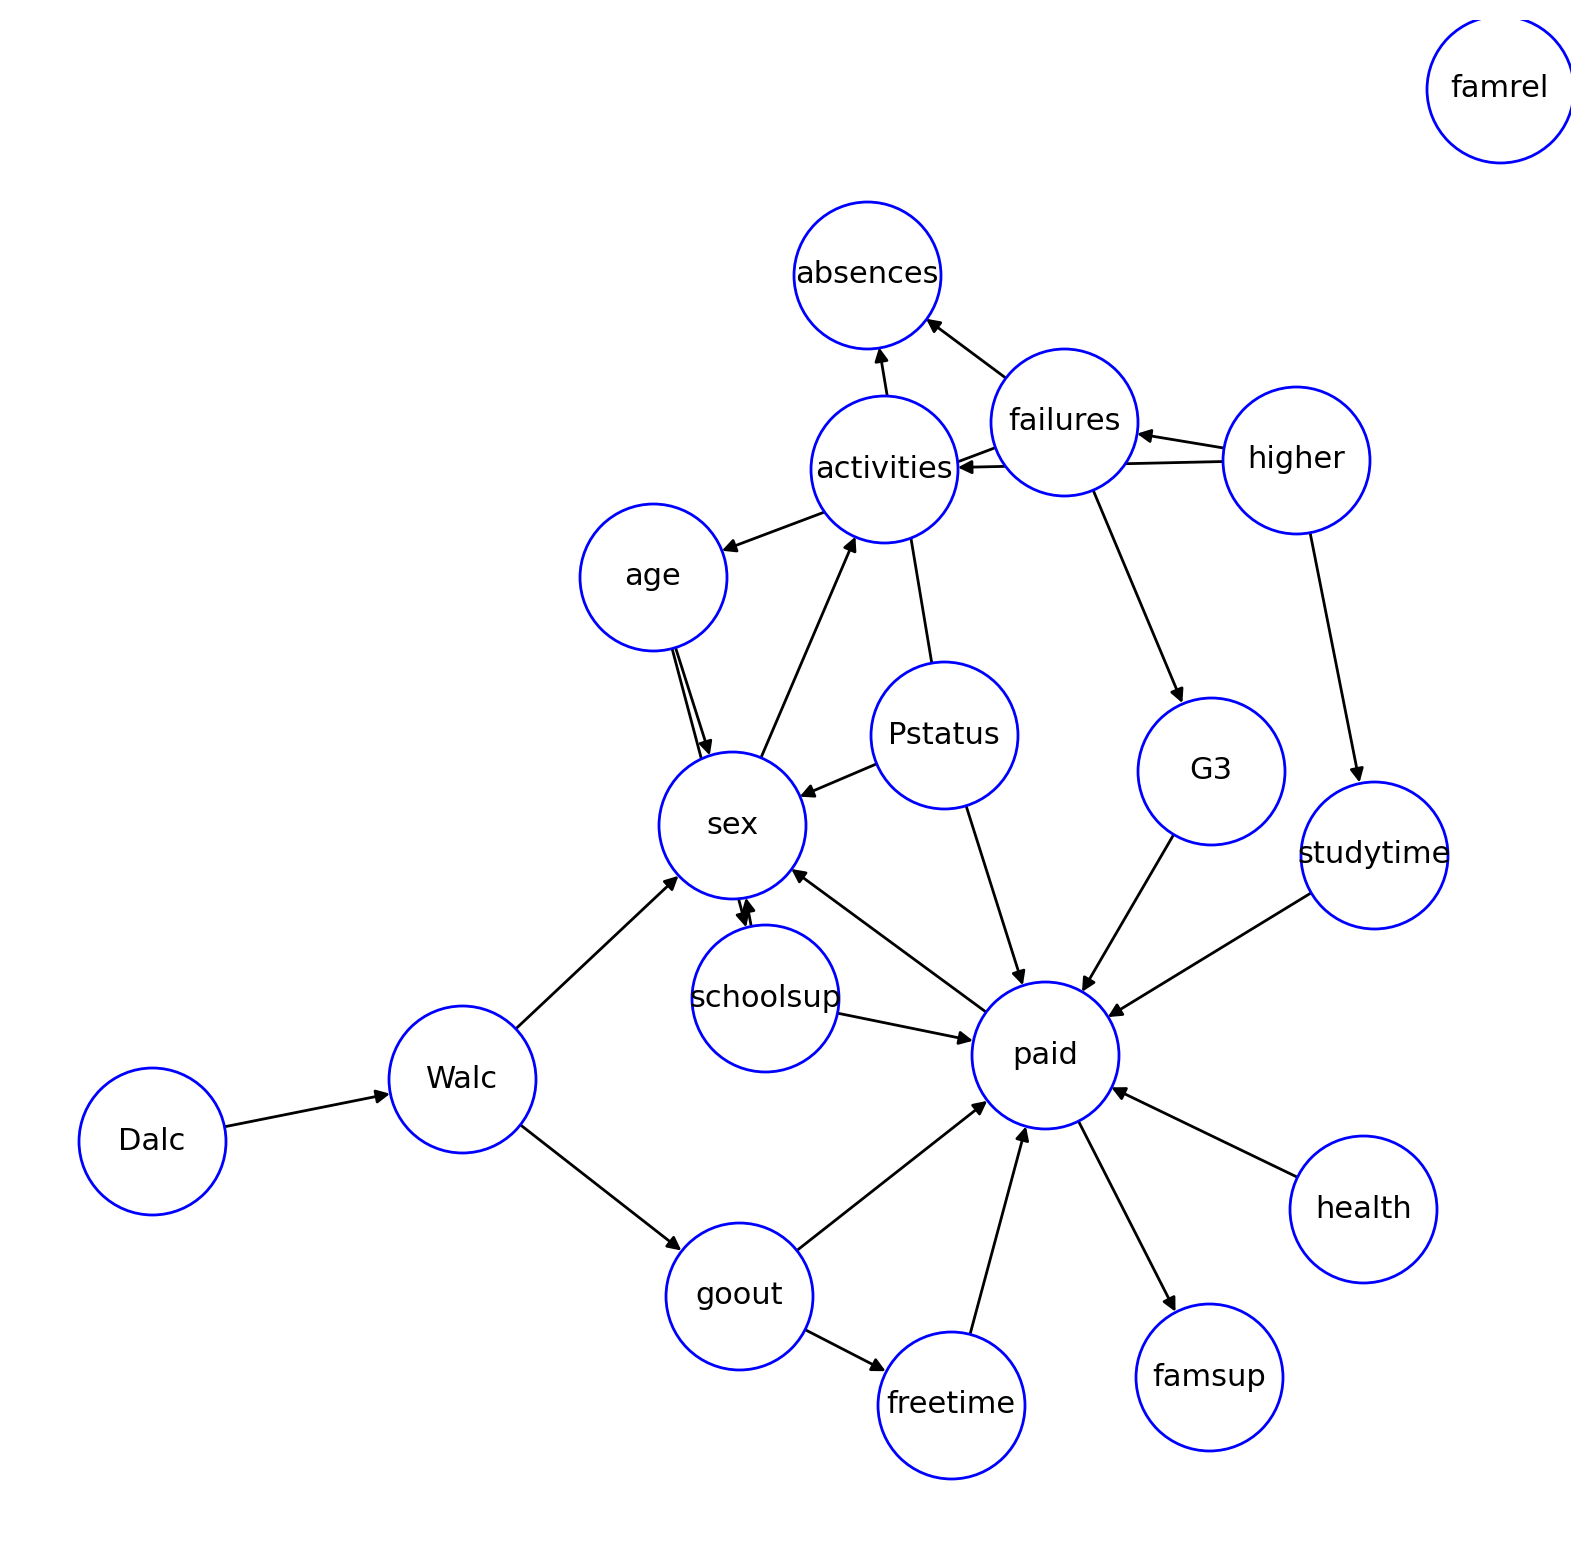

In [21]:
result_HCS = parameter_test_HCS()
pdags_HCS = [x[3] for x in result_HCS]
for pdag in pdags_HCS:
  print_graph(list(df.columns), pdag)

[(0, 0.13071895424836602, 0.8333333333333334, [('Dalc', 'Walc'), ('Pstatus', 'absences'), ('Walc', 'goout'), ('age', 'failures'), ('age', 'schoolsup'), ('failures', 'G3'), ('failures', 'absences'), ('famsup', 'paid'), ('goout', 'freetime'), ('higher', 'failures'), ('higher', 'studytime'), ('higher', 'age'), ('higher', 'sex'), ('higher', 'activities'), ('higher', 'freetime'), ('paid', 'higher'), ('sex', 'Dalc'), ('sex', 'freetime'), ('sex', 'activities'), ('studytime', 'sex')]), (1, 0.13725490196078433, 0.8333333333333334, [('Pstatus', 'absences'), ('G3', 'paid'), ('studytime', 'sex'), ('sex', 'Dalc'), ('sex', 'freetime'), ('sex', 'activities'), ('Walc', 'goout'), ('Dalc', 'Walc'), ('age', 'failures'), ('age', 'schoolsup'), ('goout', 'freetime'), ('failures', 'G3'), ('failures', 'absences'), ('higher', 'studytime'), ('higher', 'failures'), ('higher', 'paid'), ('higher', 'age'), ('higher', 'sex'), ('higher', 'activities'), ('higher', 'freetime'), ('paid', 'famsup')]), (2, 0.1633986928104

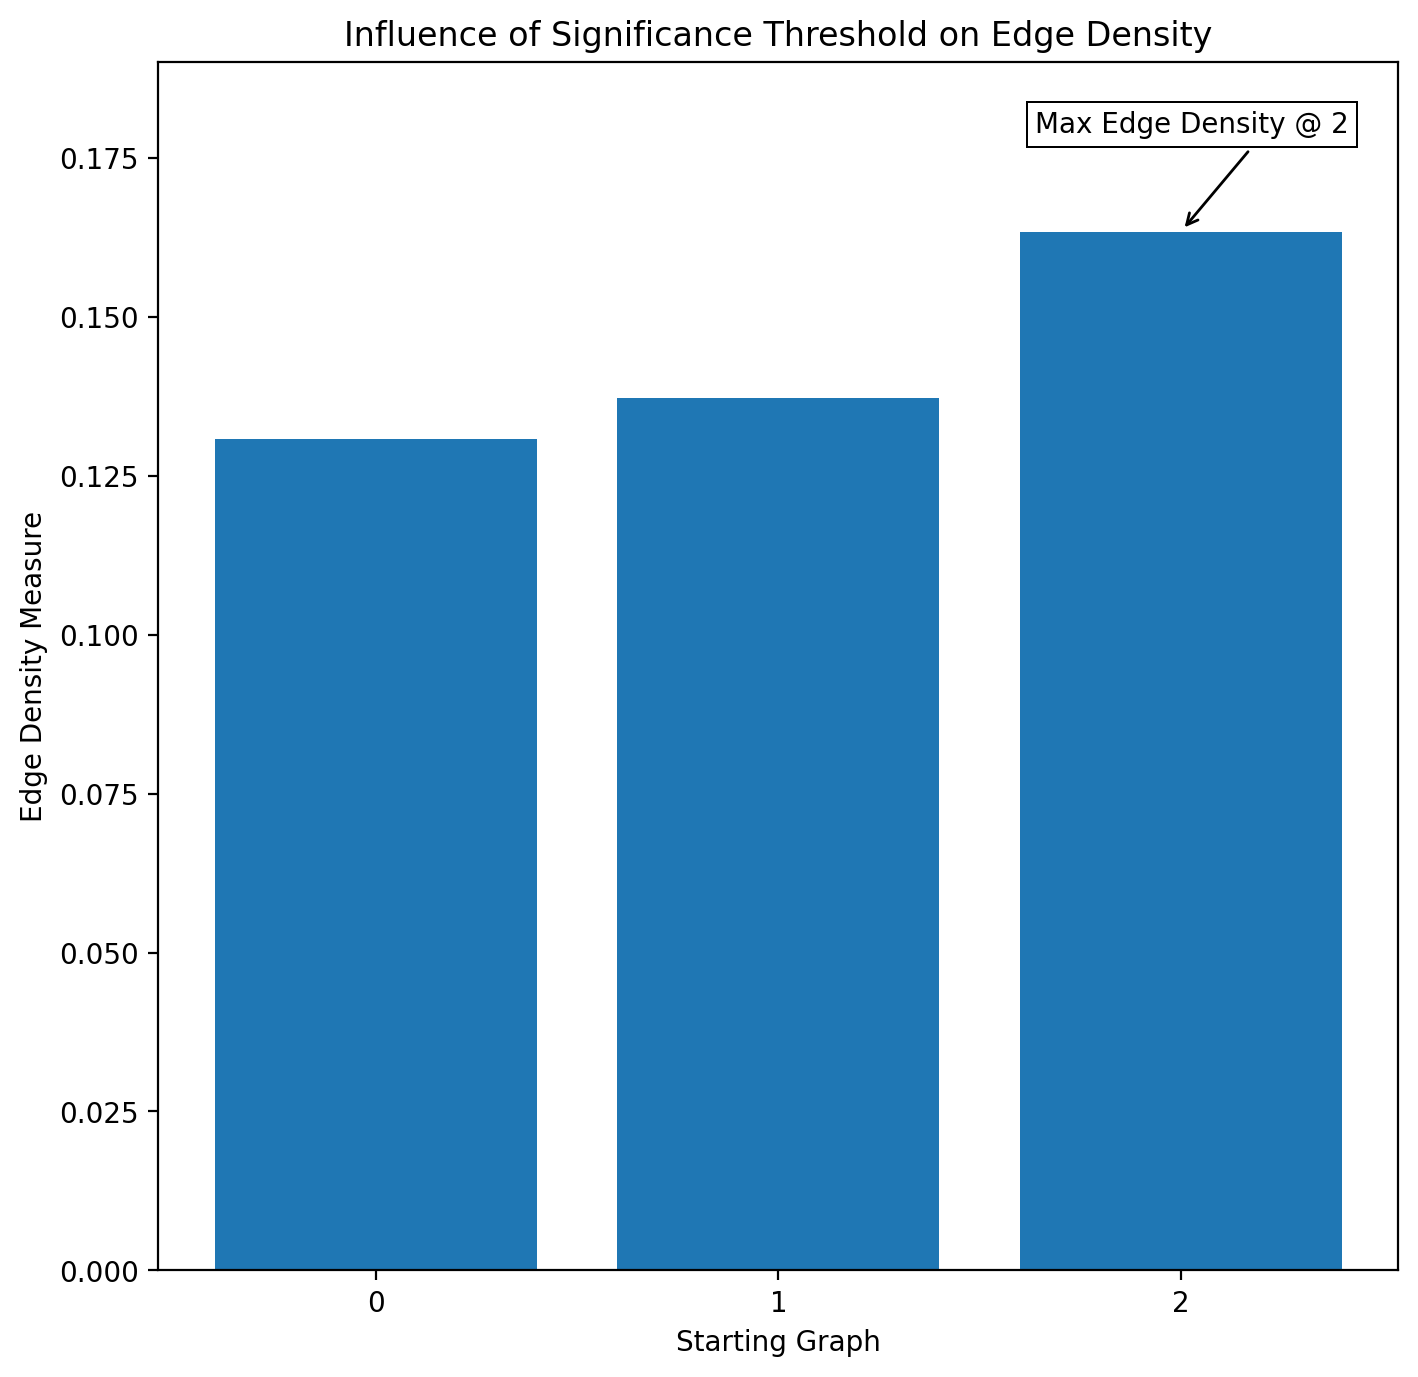

In [22]:
fig, ax=plt.subplots(figsize=(8, 8), dpi=dpi)
print(result_HCS)
plt.bar([x[0] for x in result_HCS], [x[1] for x in result_HCS], )
plt.title('Influence of Significance Threshold on Edge Density')
plt.ylabel('Edge Density Measure')
plt.xlabel('Starting Graph')
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    text= f"Max Edge Density @ {xmax}"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=50")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.96,0.96), **kw)

annot_max([x[0] for x in result_HCS], [x[1] for x in result_HCS])
ax.set_ylim(0,0.19)
plt.show()

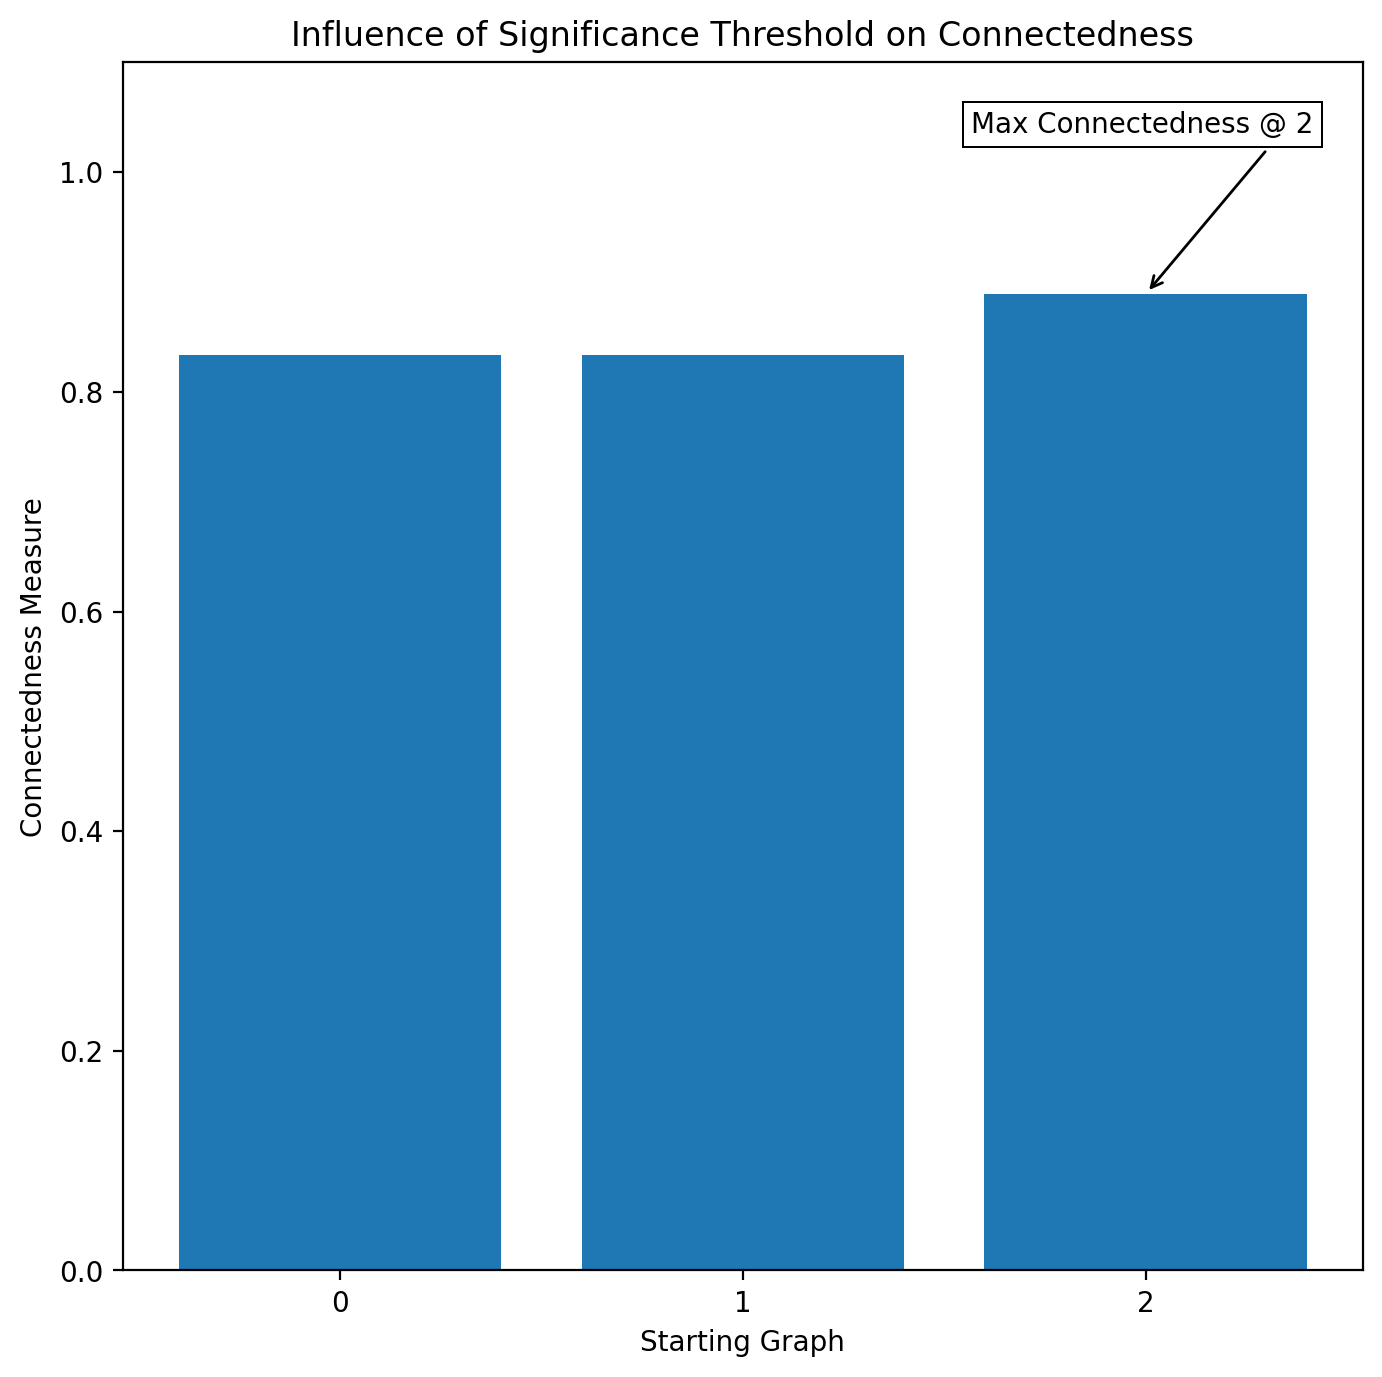

In [23]:
fig, ax=plt.subplots(figsize=(8, 8), dpi=dpi)
plt.bar([x[0] for x in result_HCS], [x[2] for x in result_HCS], )
plt.title('Influence of Significance Threshold on Connectedness') 
plt.ylabel('Connectedness Measure')
plt.xlabel('Starting Graph')
print()
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    text= f"Max Connectedness @ {xmax}"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=50")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.96,0.96), **kw)

annot_max([x[0] for x in result_HCS], [x[2] for x in result_HCS])
ax.set_ylim(0,1.1)
plt.show()

### Experiment 3: Measure Tests
In this experiment, we created all possible subsets of nodes and ran both PC and HCS algorithms on all subsets. This allows us to view how the algorithms perform with different datasets, especially what the effect of the size of the network is.

In [24]:
metric_test, all_subgraphs = compare_algorithms_all_subgraphs()

#### Experiment 3: Influence of Node Count on Edge Density using PC
We test on a list of subsets sorted by subset size, what the score of our edge density score is on the resulting networks.

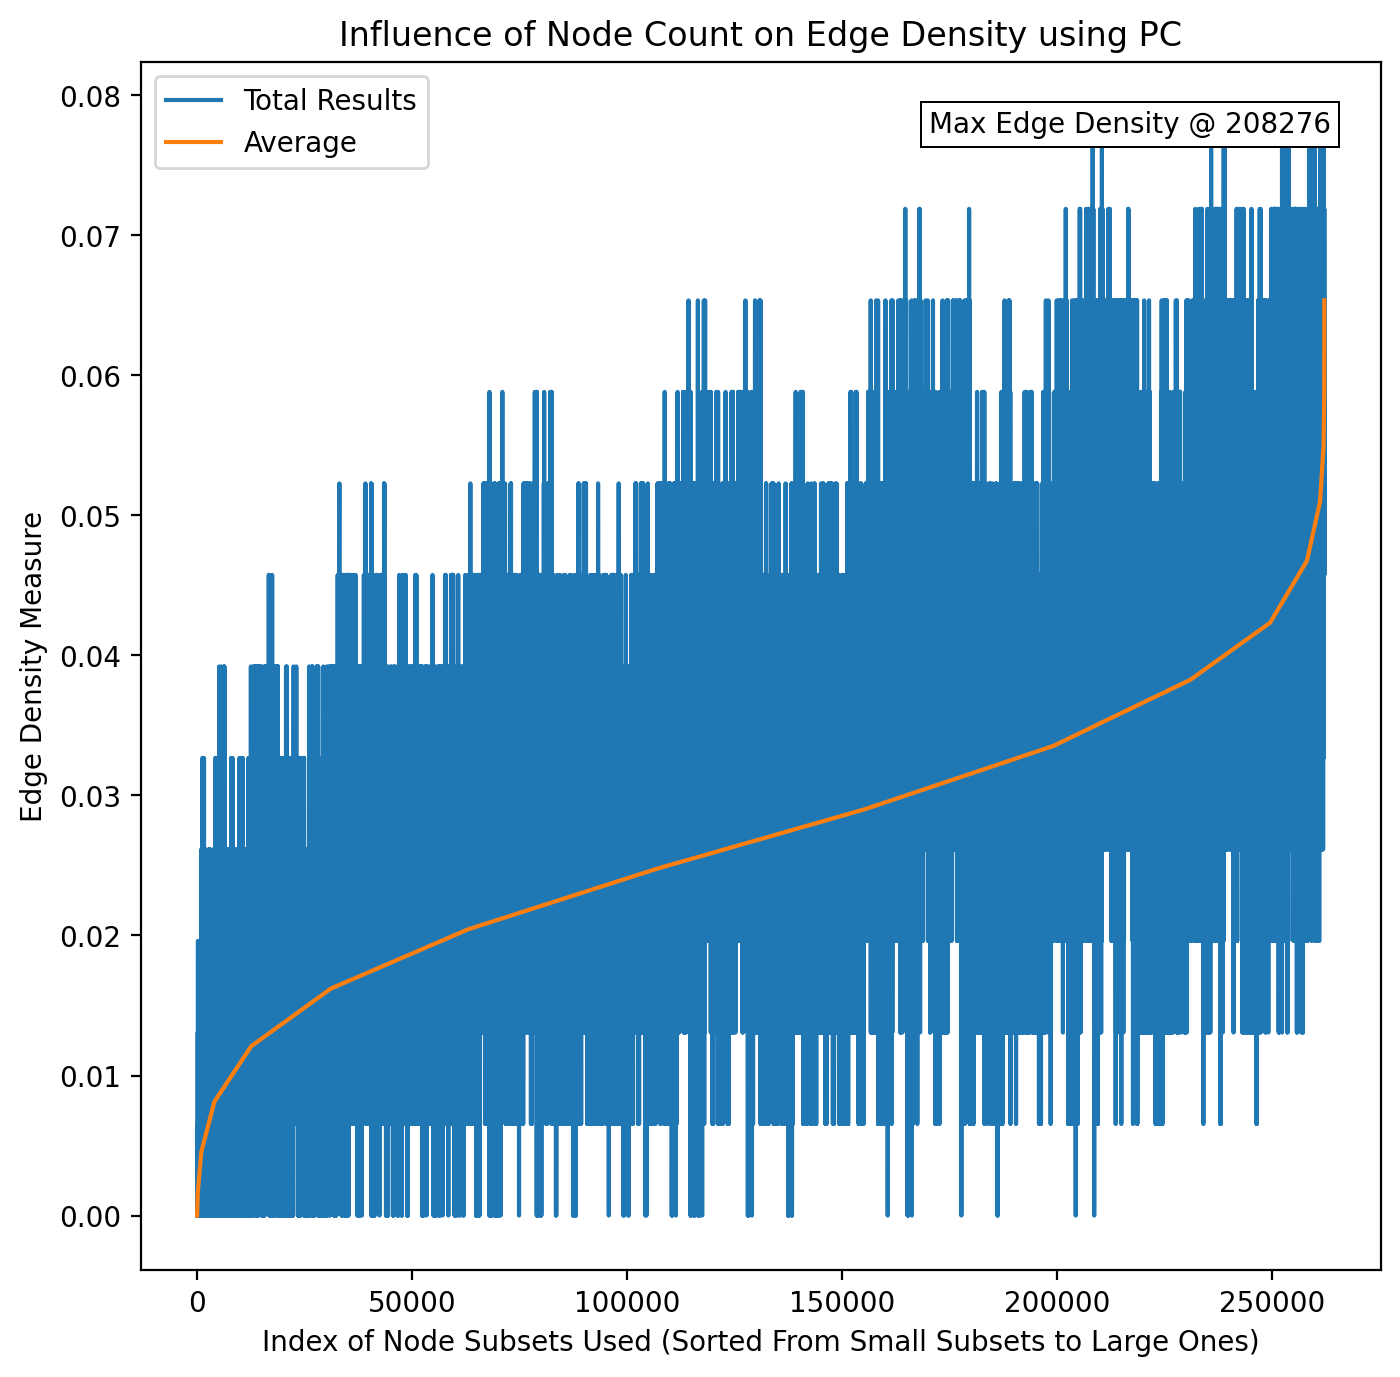

In [25]:
fig, ax=plt.subplots(figsize=(8, 8), dpi=dpi)
plt.plot([x[0] for x in metric_test], [x[3] for x in metric_test], label="Total Results")
plt.title('Influence of Node Count on Edge Density using PC') 
plt.ylabel('Edge Density Measure')
plt.xlabel('Index of Node Subsets Used (Sorted From Small Subsets to Large Ones)')
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    text= f"Max Edge Density @ {xmax}"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=50")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.96,0.96), **kw)

annot_max([x[0] for x in metric_test], [x[3] for x in metric_test])
plt.plot(np.cumsum([len(x) for x in (mean_per_size(metric_test, all_subgraphs, 3)[1][1:])]), mean_per_size(metric_test, all_subgraphs, 3)[0], label='Average')
# ax.set_ylim(0,0.13)
plt.legend()
plt.show()

#### Experiment 3: Influence of Node Count on Edge Density using HCS
We test on a list of subsets sorted by subset size, what the score of our edge density measure is on the resulting networks.:

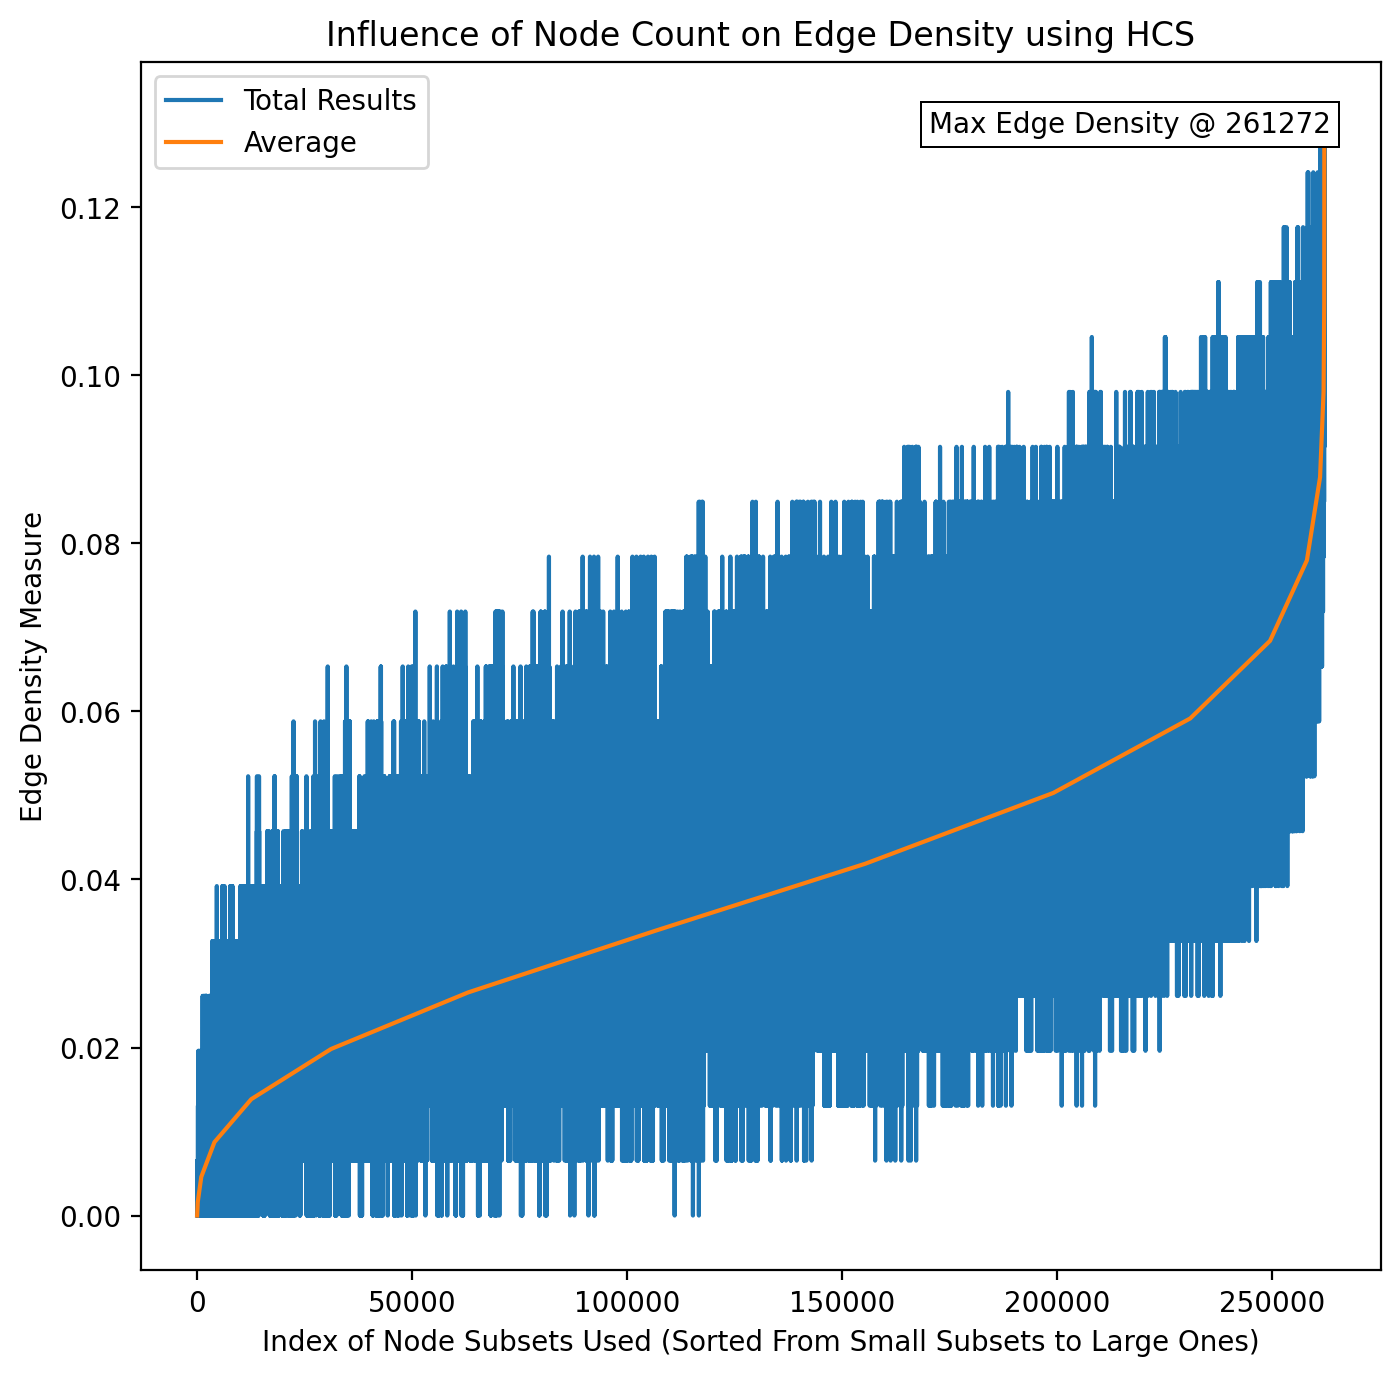

In [26]:
fig, ax=plt.subplots(figsize=(8, 8), dpi=dpi)
plt.plot([x[0] for x in metric_test], [x[4] for x in metric_test], label="Total Results")
plt.title('Influence of Node Count on Edge Density using HCS') 
plt.ylabel('Edge Density Measure')
plt.xlabel('Index of Node Subsets Used (Sorted From Small Subsets to Large Ones)')
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    text= f"Max Edge Density @ {xmax}"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=50")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.96,0.96), **kw)

annot_max([x[0] for x in metric_test], [x[4] for x in metric_test])
plt.plot(np.cumsum([len(x) for x in (mean_per_size(metric_test, all_subgraphs, 4)[1][1:])]), mean_per_size(metric_test, all_subgraphs, 4)[0], label='Average')
# ax.set_ylim(0,0.13)
plt.legend()
# plt.show()
plt.savefig("test.svg", format="svg")


#### Experiment 3: Influence of Node Count on Connectedness using PC
We test on a list of subsets sorted by subset size, what the score of our connectedness measure is on the resulting networks.:



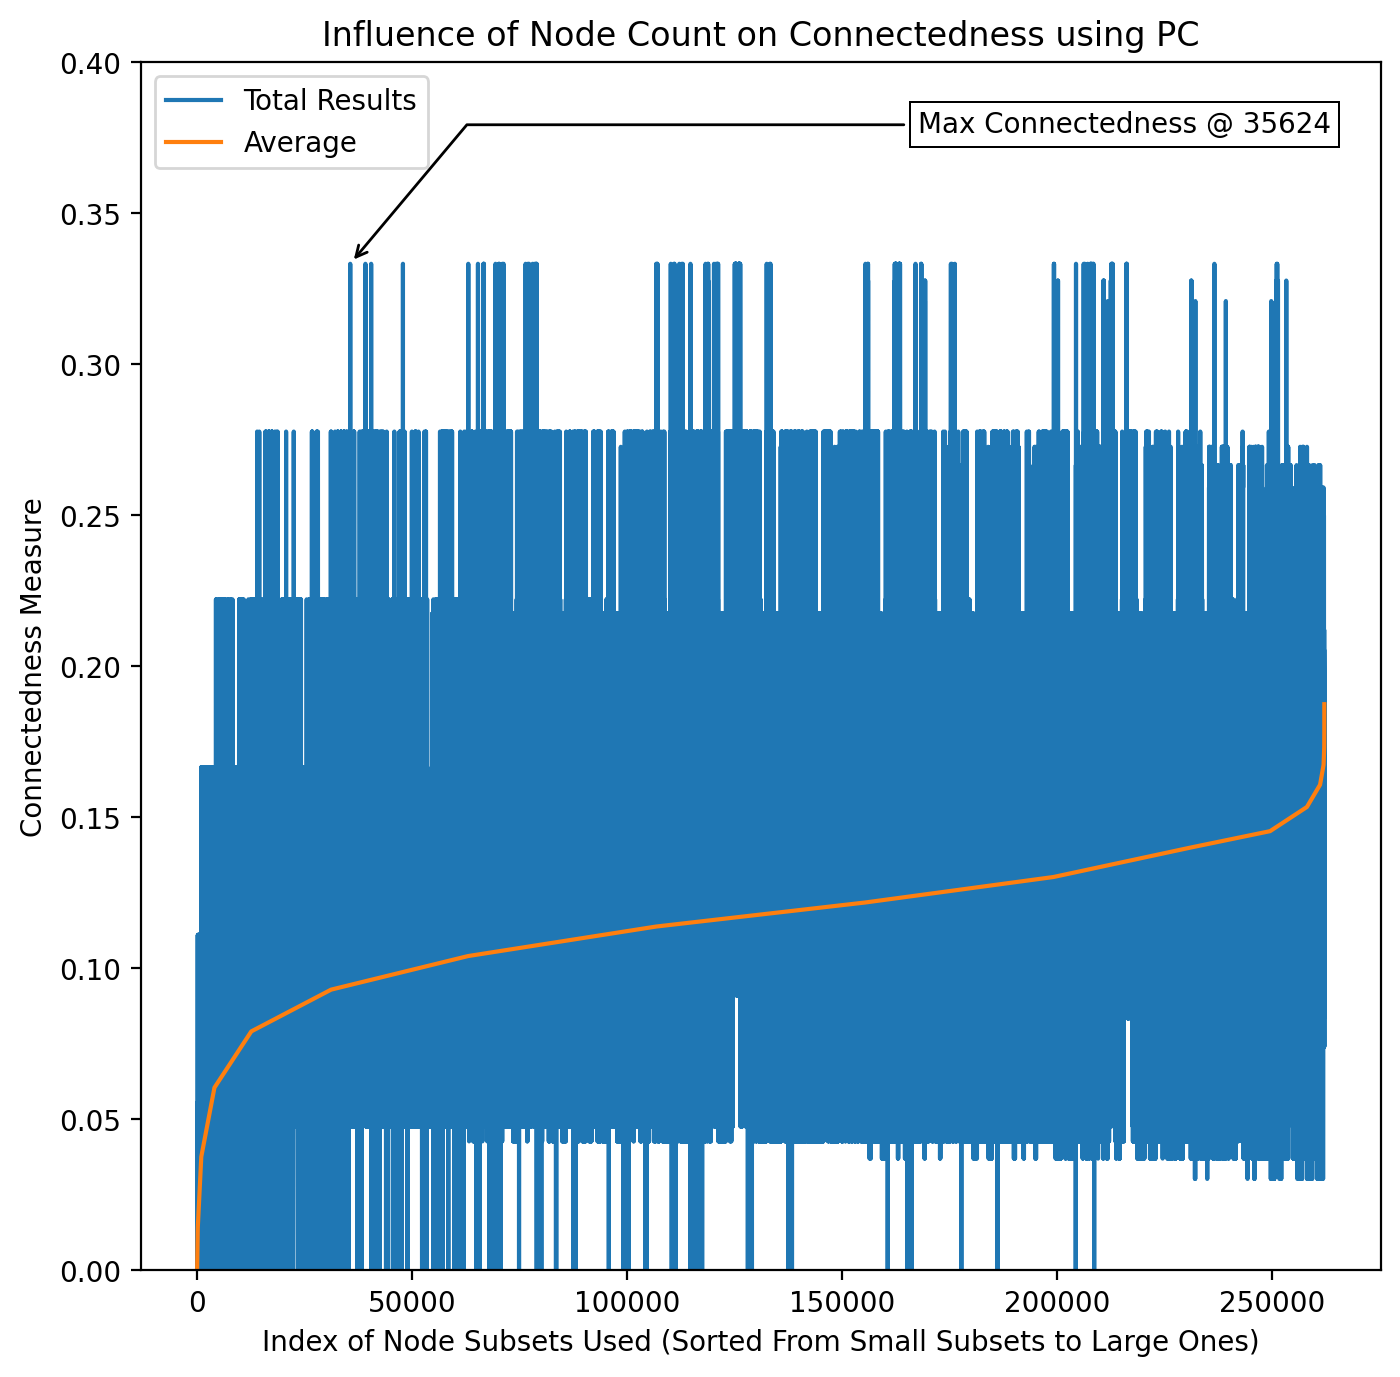

In [27]:
fig, ax=plt.subplots(figsize=(8, 8), dpi=dpi)
plt.plot([x[0] for x in metric_test], [x[5] for x in metric_test], label="Total Results")
plt.title('Influence of Node Count on Connectedness using PC') 
plt.ylabel('Connectedness Measure')
plt.xlabel('Index of Node Subsets Used (Sorted From Small Subsets to Large Ones)')
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    text= f"Max Connectedness @ {xmax}"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=50")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.96,0.96), **kw)

annot_max([x[0] for x in metric_test], [x[5] for x in metric_test])
plt.plot(np.cumsum([len(x) for x in (mean_per_size(metric_test, all_subgraphs, 5)[1][1:])]), mean_per_size(metric_test, all_subgraphs, 5)[0], label='Average')
ax.set_ylim(0,0.4)
plt.legend(loc="upper left")
plt.show()

#### Experiment 3: Influence of Node Count on Connectedness using HCS
We test on a list of subsets sorted by subset size, what the score of our connectedness measure is on the resulting networks.

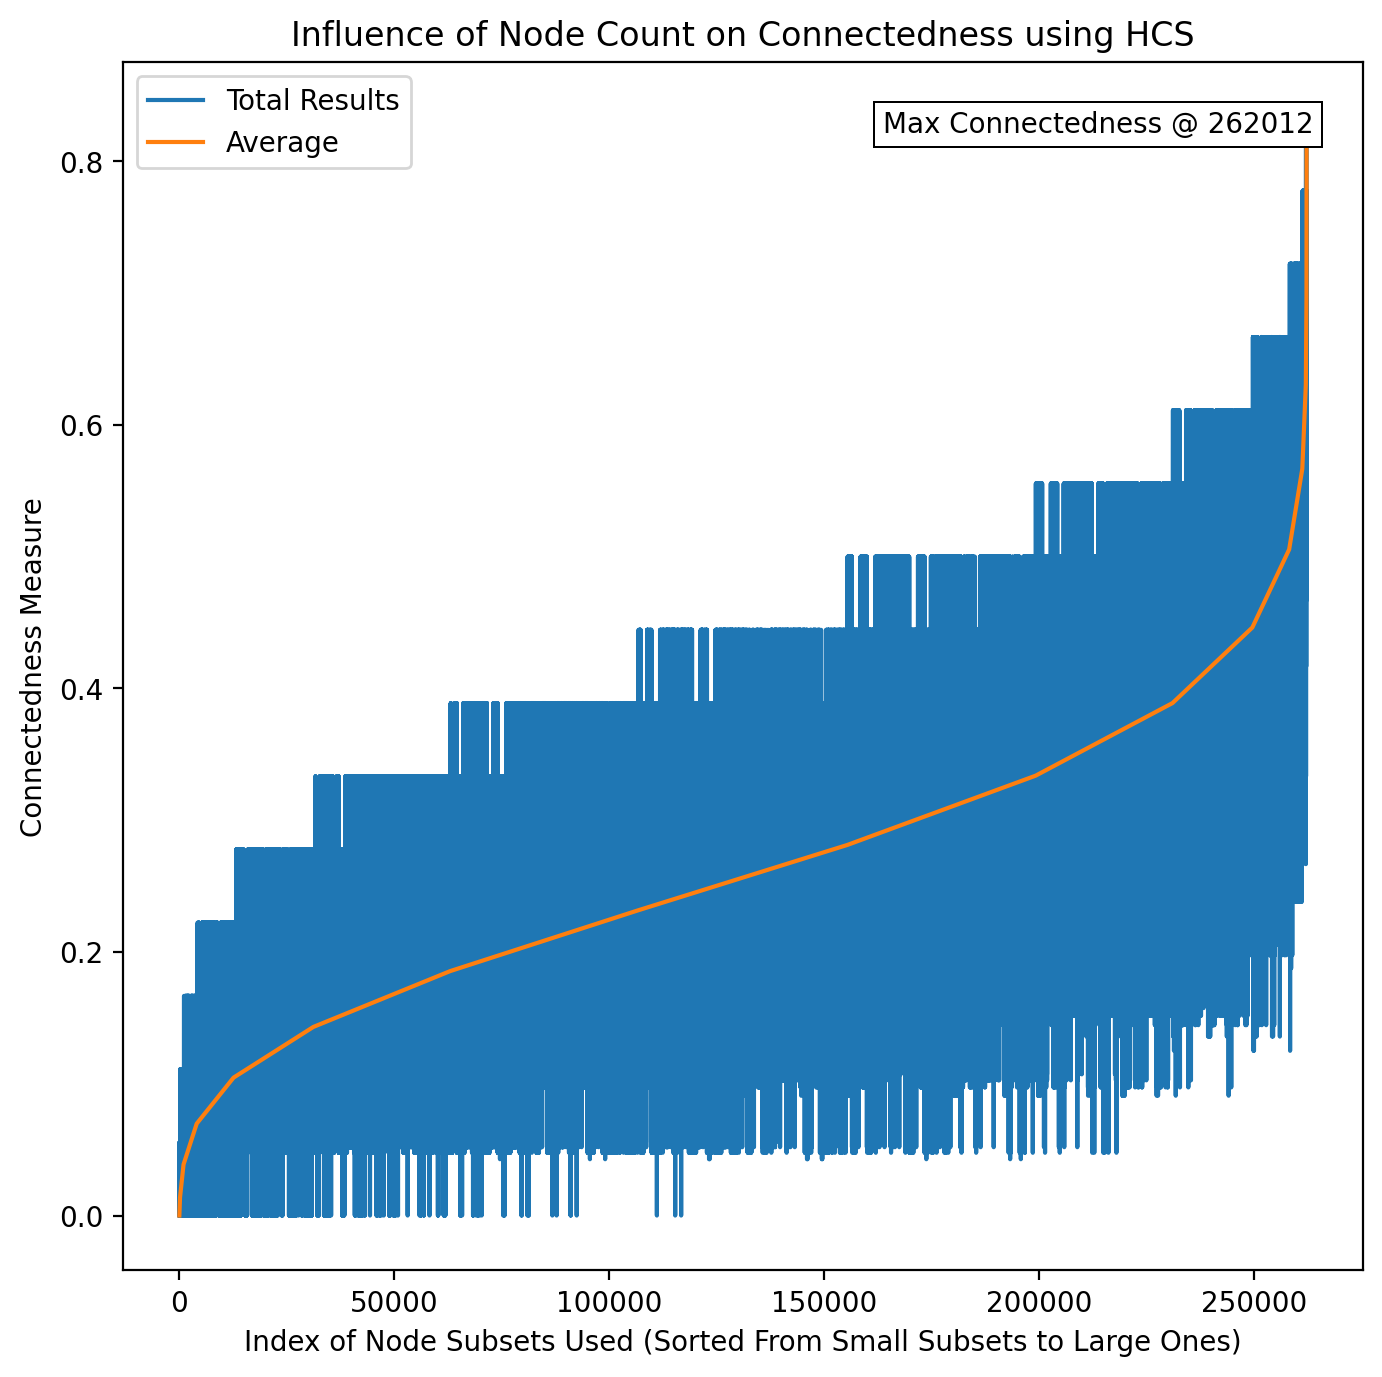

In [28]:
fig, ax=plt.subplots(figsize=(8, 8), dpi=dpi)
plt.plot([x[0] for x in metric_test], [x[6] for x in metric_test], label="Total Results")
plt.title('Influence of Node Count on Connectedness using HCS') 
plt.ylabel('Connectedness Measure')
plt.xlabel('Index of Node Subsets Used (Sorted From Small Subsets to Large Ones)')
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)
    text= f"Max Connectedness @ {xmax}"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=50")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.96,0.96), **kw)

annot_max([x[0] for x in metric_test], [x[6] for x in metric_test])
plt.plot(np.cumsum([len(x) for x in (mean_per_size(metric_test, all_subgraphs, 6)[1][1:])]), mean_per_size(metric_test, all_subgraphs, 6)[0], label='Average')
# ax.set_ylim(0,0.13)
plt.legend()
plt.show()

#### Experiment 3: Relative Performance of PC and HCS on increasingly large networks using metric 1
In this experiment, we look at the relative performance as measured by metric 1 on the same data as all other measurements in experiment 3.

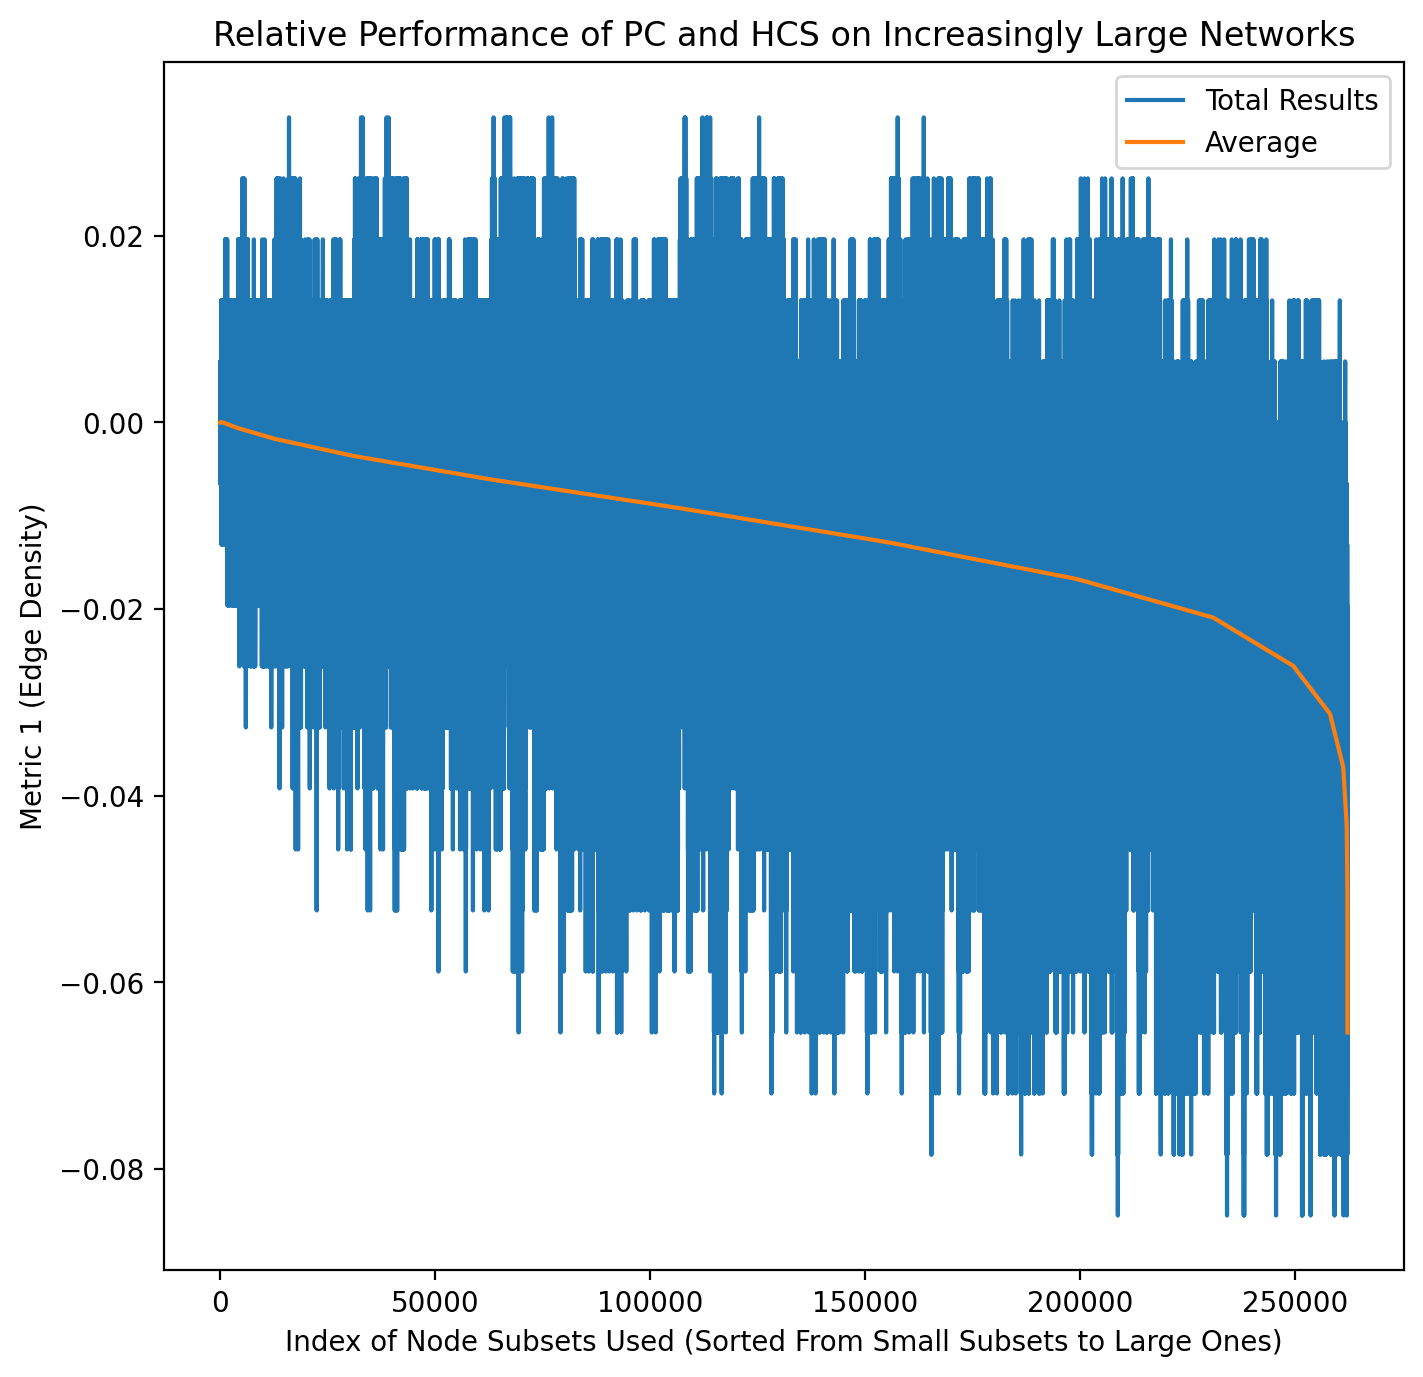

In [29]:
fig, ax=plt.subplots(figsize=(8, 8), dpi=dpi)
plt.plot([x[0] for x in metric_test], [x[1] for x in metric_test], label="Total Results")
plt.title('Relative Performance of PC and HCS on Increasingly Large Networks') 
plt.ylabel('Metric 1 (Edge Density)')
plt.xlabel('Index of Node Subsets Used (Sorted From Small Subsets to Large Ones)')
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.plot(np.cumsum([len(x) for x in (mean_per_size(metric_test, all_subgraphs, 1)[1][1:])]), mean_per_size(metric_test, all_subgraphs, 1)[0], label='Average')
# ax.set_ylim(0,0.13)
plt.legend()
plt.show()

We can see that the relative performance favours HCS almost right from the start.

#### Experiment 3: Relative Performance of PC and HCS on increasingly large networks using metric 2
In this experiment, we look at the relative performance as measured by metric 2 on the same data as all other measurements in experiment 3.

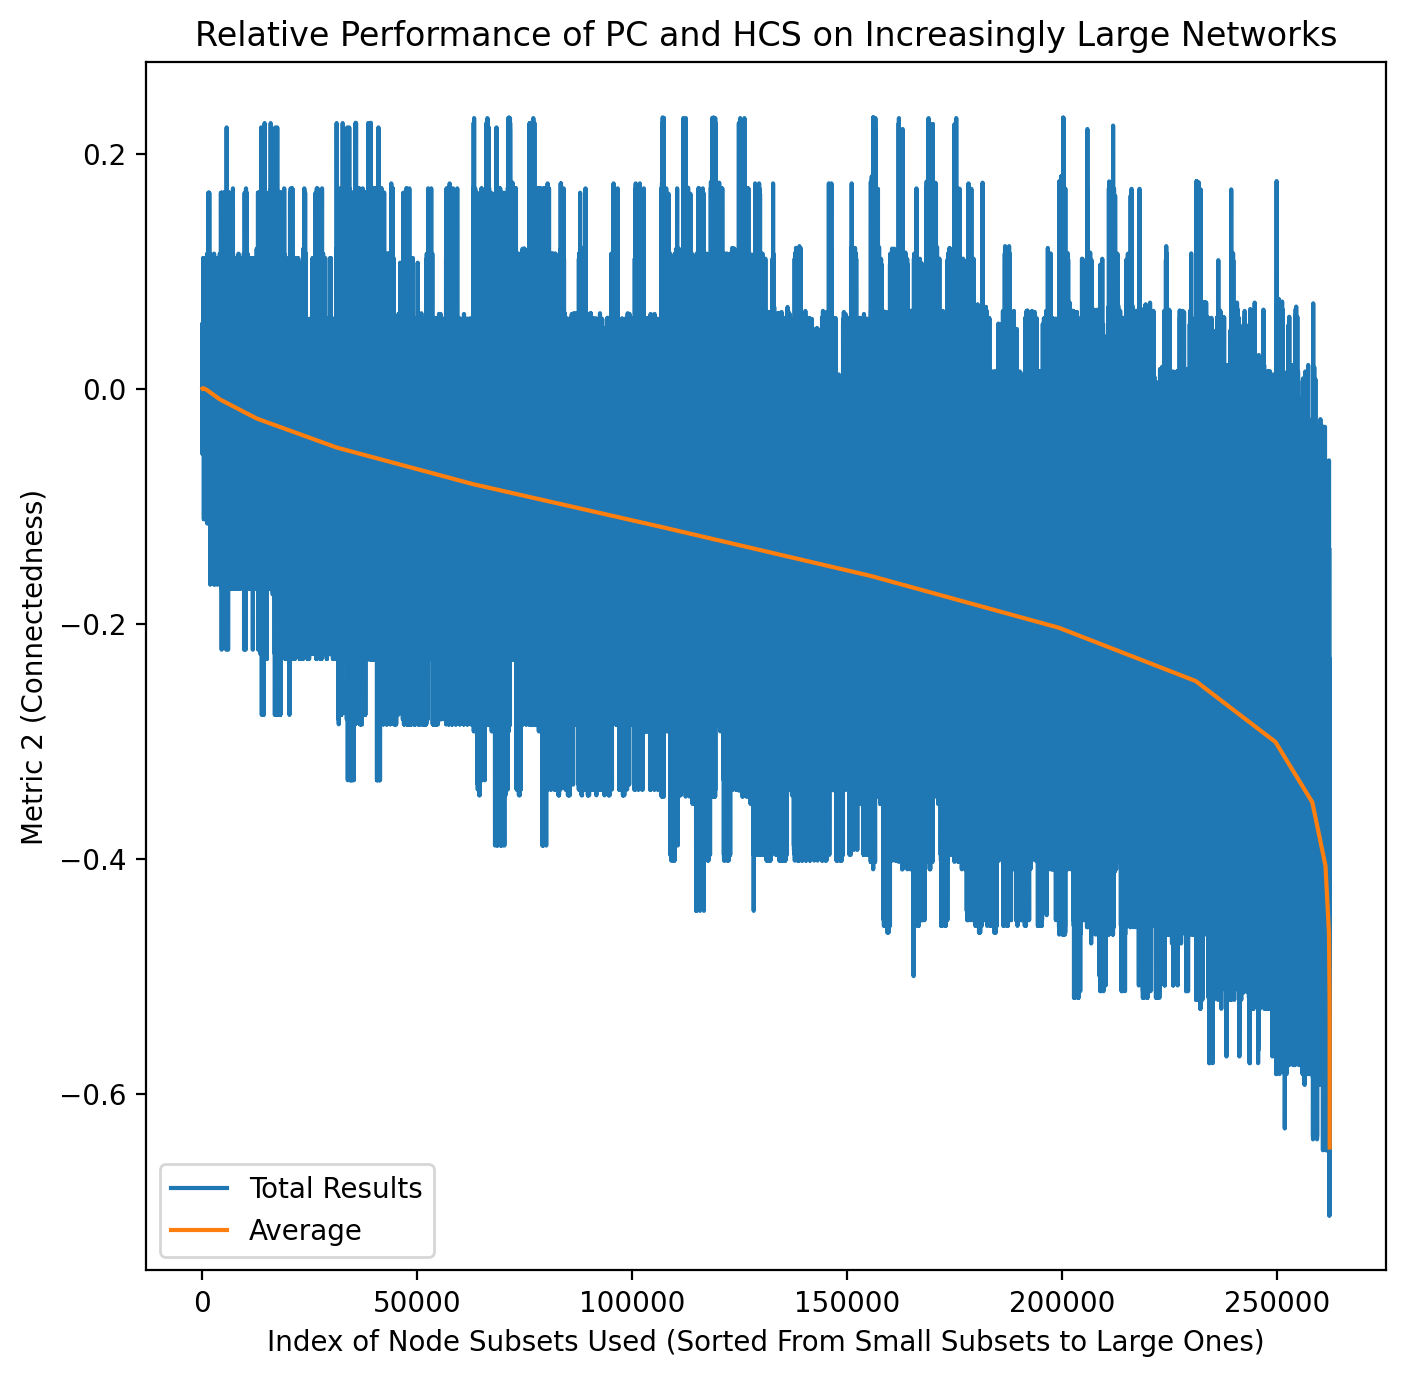

In [30]:
fig, ax=plt.subplots(figsize=(8, 8), dpi=dpi)
plt.plot([x[0] for x in metric_test], [x[2] for x in metric_test], label="Total Results")
plt.title('Relative Performance of PC and HCS on Increasingly Large Networks') 
plt.ylabel('Metric 2 (Connectedness)')
plt.xlabel('Index of Node Subsets Used (Sorted From Small Subsets to Large Ones)')
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5)) 
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.plot(np.cumsum([len(x) for x in (mean_per_size(metric_test, all_subgraphs, 2)[1][1:])]), mean_per_size(metric_test, all_subgraphs, 2)[0], label='Average')
# ax.set_ylim(0,0.13)
plt.legend()
plt.show()

Again, we can see that the relative performance favours HCS almost right from the start.

  0%|          | 0/5 [00:00<?, ?it/s]

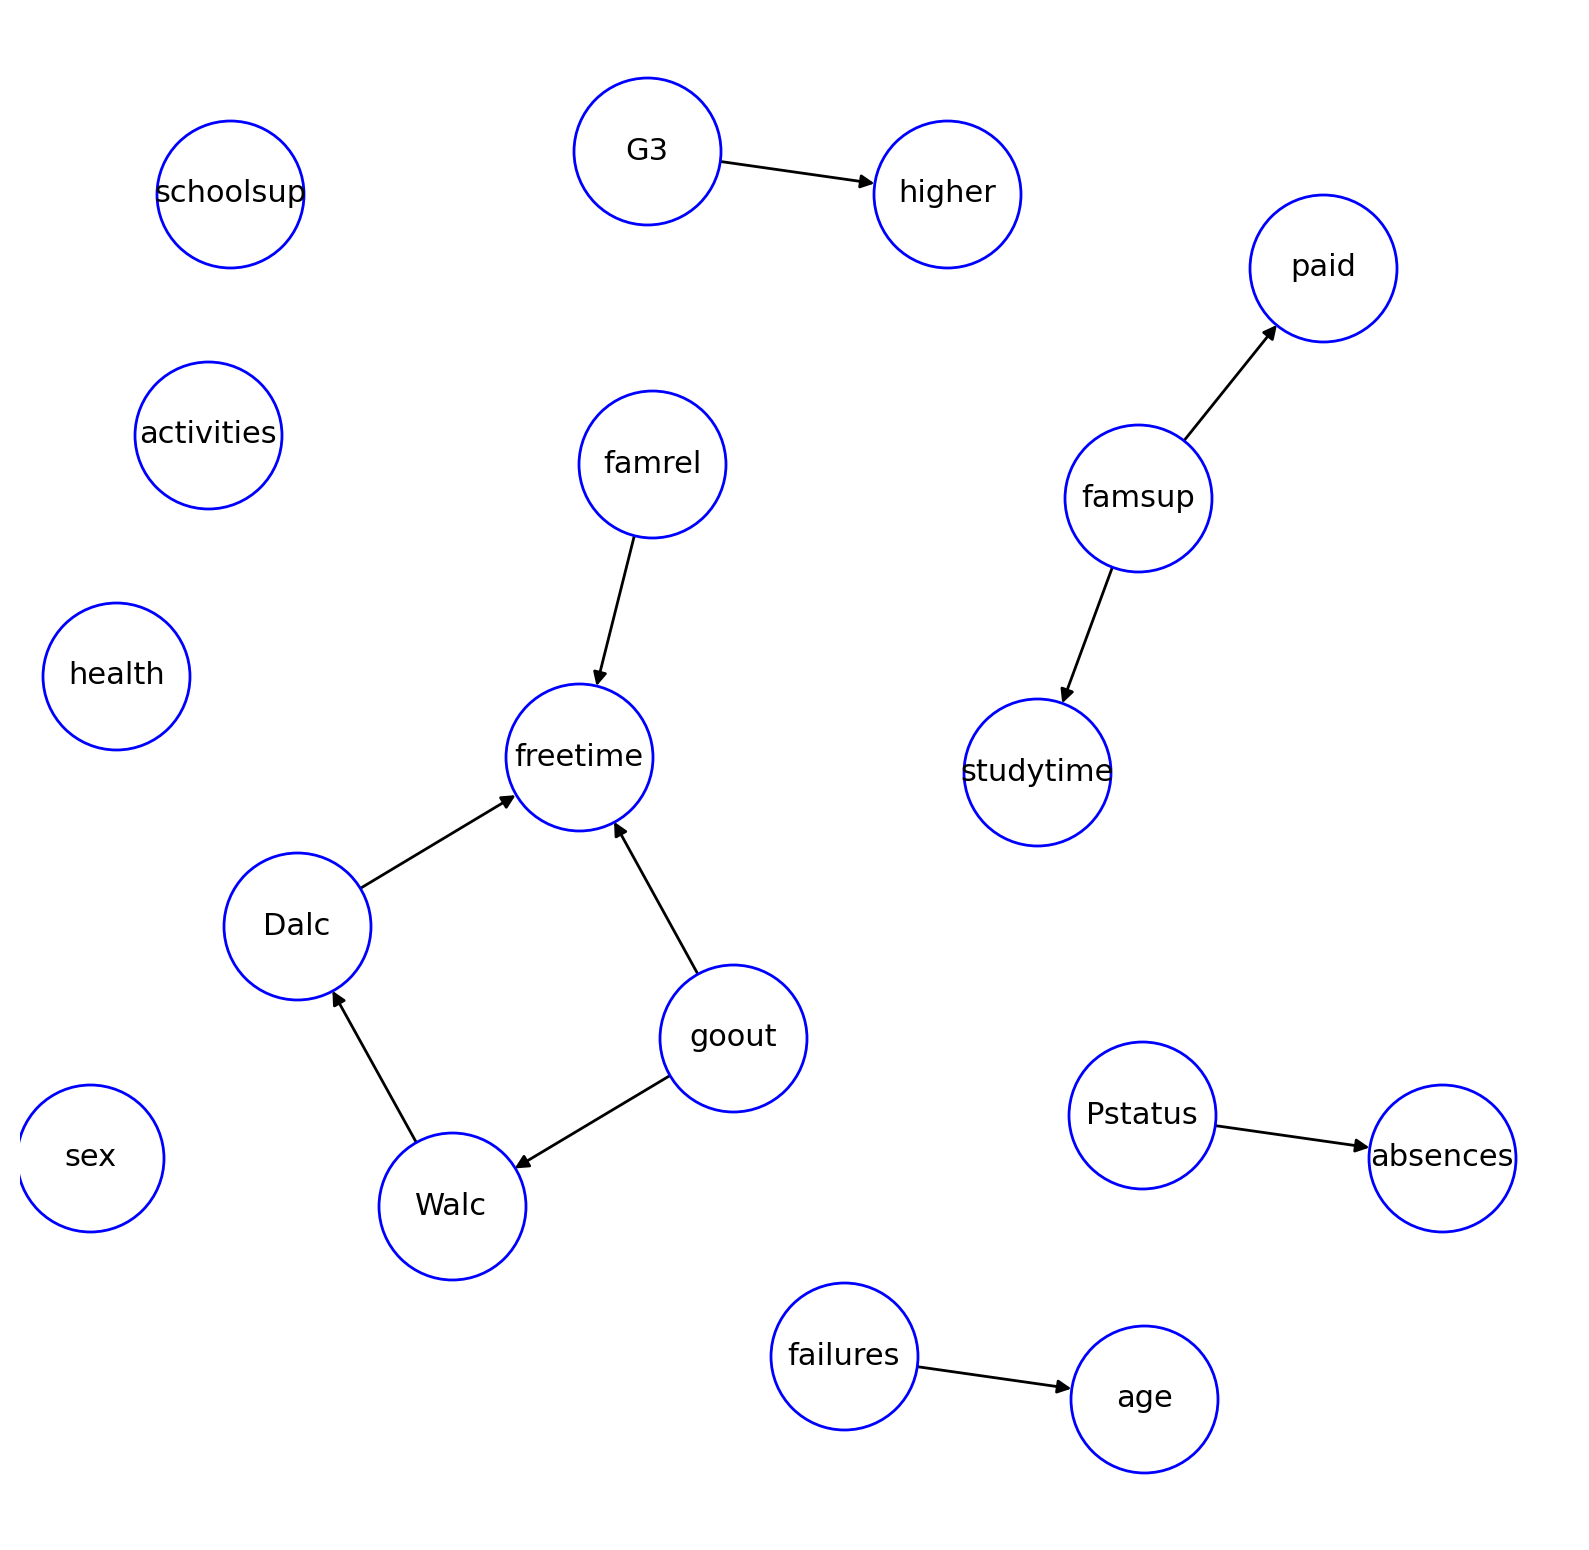

In [31]:
est_PC = PC(data=df).estimate(variant='stable', 
                              ci_test='pearsonr', 
                              max_cond_vars=5, 
                              return_type='pdag', 
                              significance_level=0.01)
print_graph(list(df.columns), list(est_PC.edges))

  0%|          | 0/1000000 [00:00<?, ?it/s]

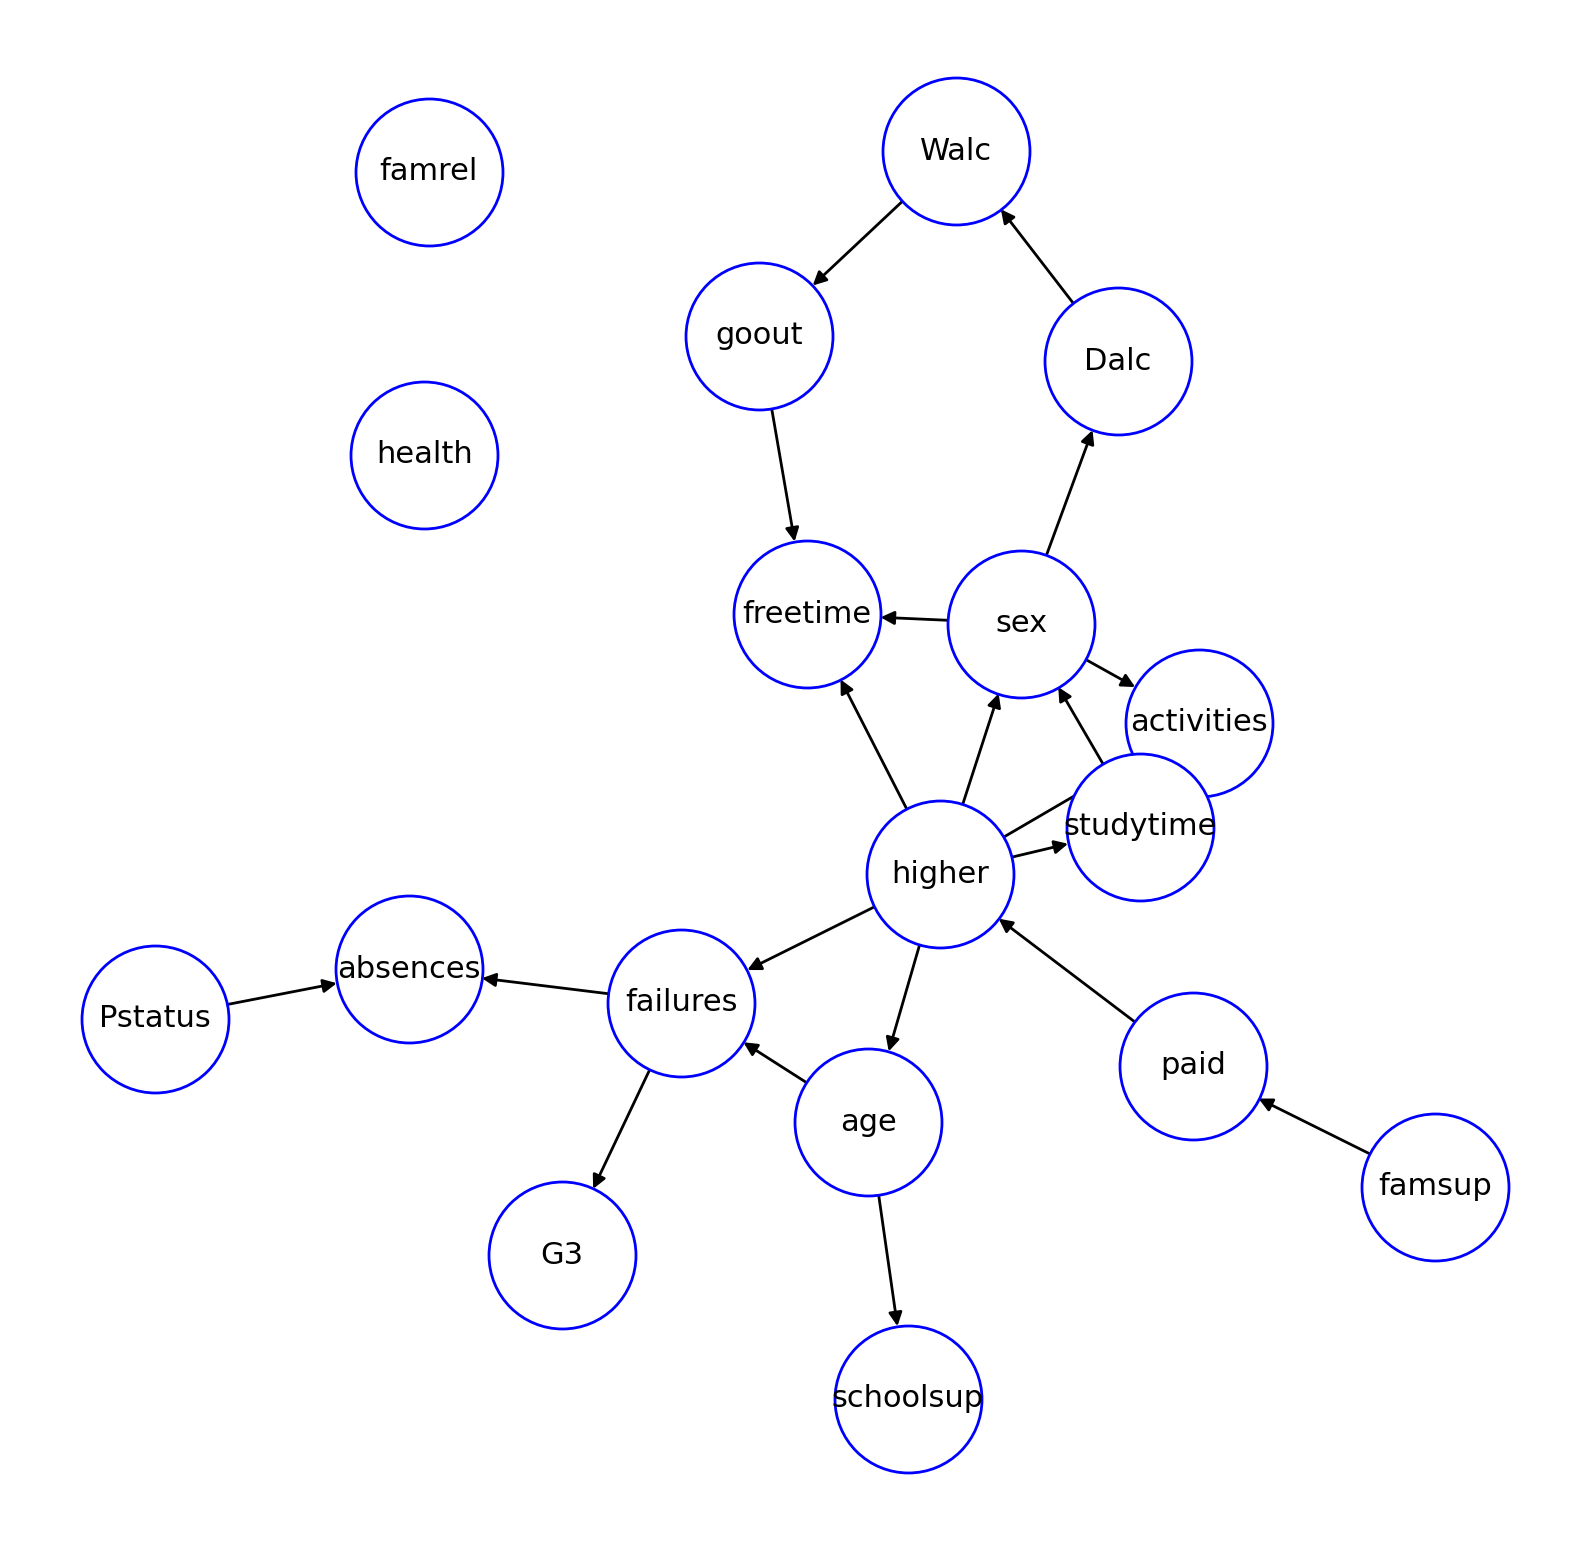

In [32]:
est_HCS = HillClimbSearch(data=df).estimate(scoring_method=K2Score(data=df), 
                                            start_dag=None, 
                                            fixed_edges={}, 
                                            tabu_length=1000, 
                                            max_indegree=None, 
                                            black_list=None, 
                                            white_list=None, 
                                            epsilon=0.00001, 
                                            max_iter=1000000.0, 
                                            show_progress=True)
print_graph(list(df.columns), list(est_HCS.edges))

In [33]:
print("Comparison with Metric 1:", metric1(list(df.columns), list(est_PC.edges), list(df.columns), list(est_HCS.edges)))
print("Comparison with Metric 2:", metric2(list(df.columns), list(est_PC.edges), list(df.columns), list(est_HCS.edges)))

Comparison with Metric 1: -0.06535947712418301
Comparison with Metric 2: -0.6458333333333334


In [34]:
if(len(list(df.columns))<5):
  est_MC = MmhcEstimator(data=df).estimate(scoring_method=K2Score(data=df), tabu_length=100, significance_level=0.01)
  print_graph(list(df.columns), list(est_MC.edges))

In [35]:
if(len(list(df.columns))<5):
  # est_ES = ExhaustiveSearch(data=df, scoring_method=BDeuScore(data=df, equivalent_sample_size=30)).estimate()
  # est_ES = ExhaustiveSearch(data=df, scoring_method=BicScore(data=df)).estimate()
  # est_ES = ExhaustiveSearch(data=df, scoring_method=K2Score(data=df)).estimate()
  est_ES = ExhaustiveSearch(data=df, scoring_method=BDsScore(data=df, equivalent_sample_size=30)).estimate()
  print_graph(list(df.columns), list(est_ES.edges))